In [1]:
!which python
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/users/ujjwal.upadhyay/miniconda3/envs/train/bin/python


In [51]:
%%html
<style type='text/css'>
.CodeMirror{
    font-size: 14.5px;
}

div.output_area pre {
    font-size: 14.5px;
}
</style>

In [236]:
gpus_dev = {
    "e2e7": [0,1,2,3],
    "e2e8": [0,1,2,3],
    "e2e10": [0,1],
    "e2e9": [0],
    "e2e4": [0],
}

In [121]:
import os
import json
import yaml
import munch
import qtrain
from glob import glob
from datetime import date
from tqdm.notebook import tqdm
from safetensors.torch import load_file

import torch
import torch.nn as nn
import torchmetrics as tm
import segmentation_models_pytorch as smp

from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

In [60]:
from safetensors import safe_open
def open_safetensor(series):
    with safe_open(f"/cache/datanas1/qer/all_studies_safetensor/resampled/{series}.safetensor", framework="pt", device="cpu") as f:
        arr = f.get_tensor('arr').numpy()
    return arr

In [42]:
def set_wts(df):
    df.loc[(df.acute == 1), "sample_wts"] = len(df) / df.acute.value_counts()[1]
    df.loc[(df.chronic == 1), "sample_wts"] = len(df) / df.chronic.value_counts()[1]
    df.loc[(df.acute == 1) & (df.chronic == 1), "sample_wts"] = len(df) / len(df.loc[(df.acute == 1) & (df.chronic == 1)])
    df.loc[(df.acute == 0) & (df.chronic == 0), "sample_wts"] = len(df) / len(df.loc[(df.acute == 0) & (df.chronic == 0)])
    df.loc[(df.set == "A") & (df.acute==-100), "sample_wts"] = 4.5
    return df

In [7]:
import pandas as pd
df = pd.read_json(
    "/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_10_08_23_wts_update.json"
)
df.annotpath = df.annotpath.values.astype('str')
df_train = df.loc[df.status == "train",:].reset_index(drop=True)
df_valid = df.loc[df.status == "valid",:].reset_index(drop=True)
df = pd.concat([set_wts(df_) for df_ in [df_train, df_valid]]).reset_index(drop=True)
# df.to_json("/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_10_08_23_wts_update.json")

In [8]:
df = df.drop(df[(df['acute'] == -100) & (df['chronic'] == -100)].index).reset_index(drop=True)
# df.to_json("/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_10_08_23_only_infarcts.json")

In [45]:
df_seg = df[df.annotpath!="None"].reset_index(drop=True)
df_seg['sample_wts'] = [1]*len(df_seg)
df_seg.to_json("/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_10_08_23_only_infarcts_seg.json")

In [40]:
df_seg.acute.value_counts(), df_seg.chronic.value_counts()

(acute
 -100    1098
  0       725
  1       524
 Name: count, dtype: int64,
 chronic
 -100    1098
  1       953
  0       296
 Name: count, dtype: int64)

In [88]:
failed = []
for file in tqdm(glob("/cache/datanas1/qer/all_studies_safetensor/resampled/*")):
    try:
        load_file(file)
    except:
        failed.append(file)

  0%|          | 0/67109 [00:00<?, ?it/s]

In [91]:
with open("series.txt", 'w') as f:
    for file in glob("/cache/datanas1/qer/all_studies_safetensor/resampled/*"):
        f.write(f"{file}\n")
    

In [92]:
with open("failed.txt", 'w') as f:
    for file in failed:
        f.write(f"{file}\n")

In [90]:
failed[0]

'/cache/datanas1/qer/all_studies_safetensor/resampled/1.2.840.113619.2.415.3.2831168001.922.1553570864.629.safetensor'

In [11]:
df.acute.value_counts()

acute
0    53509
1     7576
Name: count, dtype: int64

In [12]:
df.chronic.value_counts()

chronic
0    52703
1     8382
Name: count, dtype: int64

In [50]:
with open('series.txt', 'w') as f:
    for l in df.series.tolist():
        f.write(f"{l}\n")

In [7]:
len(df_valid)

22600

In [8]:
df.groupby("set").sample_wts.value_counts()

set  sample_wts
A    4.500000       1098
     5.502989        584
     6.107545        242
     33.179380       171
     19.007569       141
     94.560669        57
     20.639269        54
B    5.502989       5416
     6.107545       5046
     33.179380      1022
     19.007569       809
     20.639269       802
     94.560669       182
C    1.509764      26218
     1.111056      20341
Name: count, dtype: int64

In [227]:
from qtrain.models.unet.multitasker import MultiTaskSeqAttn
from qtrain.models.train_models import qMultiTasker

In [222]:
args.model_params

Munch({'encoder_name': 'se_resnet50', 'in_channels': 3, 'depth': 3, 'output_stride': 16, 'decoder_channels': (128, 64, 32), 'use_batchnorm': True, 'attention_type': 'scse', 'n_segmaps': 2, 'seg_activation': None, 'kernel_size': 5, 'cls_nclasses': 2, 'cls_pooling': 'avg', 'cls_dropout': 0.3, 'cls_ac_nclasses': 2, 'cls_ac_pooling': 'avg', 'cls_ac_dropout': 0.3, 'cls_normal_nclasses': 2, 'cls_normal_pooling': 'avg', 'cls_normal_dropout': 0.3, 'n_slices': 64, 'tasks': ['seg', 'infarct', 'stacked_normal'], 'combined_embedding': True})

In [228]:
args.model_params.tasks = ["seg", "infarct", "stacked_normal"]
args.model_params.combined_embedding = True
model = MultiTaskSeqAttn(args.model_params)

In [229]:
out = model(torch.randn((1,64,3,224,224)))

In [230]:
out.keys()

dict_keys(['masks', 'acute_chronic_logits', 'embedding', 'normal_logits'])

In [233]:
import torch.nn.functional as F
F.softmax(out["normal_logits"])

/tmp/ipykernel_2516171/3791619407.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(out["normal_logits"])


tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward0>)

In [271]:
torch.vstack([torch.vstack([F.softmax(out["normal_logits"]), F.softmax(out["normal_logits"])]), torch.vstack([F.softmax(out["normal_logits"]), F.softmax(out["normal_logits"])])]), 


torch.vstack([torch.vstack([torch.tensor([1]), torch.tensor([1])]), torch.vstack([torch.tensor([1]), torch.tensor([1])])])[:,0]


/tmp/ipykernel_2516171/2711966490.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.vstack([torch.vstack([F.softmax(out["normal_logits"]), F.softmax(out["normal_logits"])]), torch.vstack([F.softmax(out["normal_logits"]), F.softmax(out["normal_logits"])])]),


tensor([1, 1, 1, 1])

In [232]:
out["acute_chronic_logits"].shape, out["normal_logits"].shape,

(torch.Size([1, 2]), torch.Size([1, 2]))

In [206]:
nn.Conv2d(32, 512, 3, stride=8, padding=1)(torch.randn(64, 32, 224, 224)).shape

torch.Size([64, 512, 28, 28])

In [207]:
nn.Conv2d(args.model_params.decoder_channels[-1], 512, 3, stride=8, padding=1)(torch.randn(64, 32, 360, 360)).shape

torch.Size([64, 512, 45, 45])

In [205]:
out["embedding"].shape

torch.Size([2, 64, 512, 45, 45])

In [161]:
args.tasks = ["seg"]
assert ("normal" in args.tasks) or ("stacked_normal" in args.tasks) or ("stacked_normal" not in args.tasks and "normal" not in args.tasks)


In [292]:
wts = torch.load("/fast_data_e2e_1/ujjwal/logs/lightning_logs/version_15/checkpoints/train_loss=0.03-epoch=22-valid_metric=0.00-train_metric=0.00-valid_loss=0.02-train_loss=0.03.ckpt", map_location="cpu")
wts.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'MixedPrecisionPlugin', 'hparams_name', 'hyper_parameters'])

In [290]:
model = qMultiTasker(args)

In [296]:
model.load_state_dict(wts['state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['model.aggregator_decoder.weight', 'model.aggregator_decoder.bias'], unexpected_keys=[])

In [77]:
# qMultiTasker.load_from_checkpoint("/fast_data_e2e_1/ujjwal/logs/lightning_logs/version_15/checkpoints/valid_seg_focal=0.02-epoch=19-valid_metric=0.00-train_metric=0.00-valid_loss=0.02-train_loss=0.03.ckpt")

In [297]:
SERVER = "e2e9"

with open("template.json", "r") as f:
    args = munch.munchify(json.load(f))

args.resume_checkpoint = None
args.pretrained_checkpoint = None
args.datapath = (
    "/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_10_08_23_only_infarcts_seg.json"
)
# args.tasks = ["infarct", "seg", "slc"]
args.tasks = ["seg"]
# args.freeze_task_epoch_index = {"start":[10, 30, 50], "end": [15, 38, 60], 
#                                 "layers": [["encoder"], ["encoder"], ["encoder"]]}
args.gpu = gpus_dev[SERVER]
args.monitor = "valid_loss"
args.dataset_class_60k = True
args.save_checkpoints = "/fast_data_e2e_1/ujjwal/logs/"
args.dl_pin_memory = True
args.dl_drop_last = True
args.sampler = True
# args.sampler = None
args.train_samples = 10000
args.valid_samples = -1
args.precision = 16
args.strategy = "ddp"
args.crop = True
args.patience = 100
args.ignore_index = -100

args.n_slices = 64
args.valid_n_slices = args.n_slices
args.img_size = 360


args.max_epoch = 200
args.batch_size = 4
args.valid_batch_size = 4
args.num_workers = 12
args.prefetch = 2
args.accumulate_grad_batches = args.batch_size * len(args.gpu) * 2
args.track_grad_norm = 2

args.gradient_clip_val = 0.5
args.gradient_clip_algorithm = "norm"

args.stochastic_weight_averaging = False
if args.stochastic_weight_averaging:
    args.swa_lrs = 1e-2
    args.swa_epoch_start = 0.8

args.only_annotated = False
args.augmentation = True

args.windowing = "tensor_based"


from qtrain.metrics.jaccard import mean_iou_ignore_idx
args.point_estimates = munch.munchify({
    "seg": {
        "loss_fns": {
            "focal": smp.losses.FocalLoss(mode="multiclass", ignore_index=args.ignore_index, reduction="none"),
        },
        "loss_wts": {
            "focal": 5,
        },
        "batch_metrics": {
            "miou": mean_iou_ignore_idx,
        }
    },
#     "cls": {
#         "loss_fns": {
#             "ce": nn.CrossEntropyLoss(weight=torch.FloatTensor([2.0, 1.0]), ignore_index=args.ignore_index),
#         },
#         "loss_wts": {
#             "focal": 5,
#         },
#         "epoch_metrics": {
#             "auc": tm.AUROC(task="binary", num_classes=2, ignore_index=args.ignore_index),
#         }
#         "batch_metrics": {
#             "stats": tm.StatScores(task="binary", num_classes=2, ignore_index=args.ignore_index),
#         }
#     },
    "slc": {
        "loss_fns": {
            "bce": nn.BCEWithLogitsLoss(reduction="none"),
        },
        "loss_wts": {
            "bce": 4,
        },
        "epoch_metrics": {
            "auc": tm.AUROC(task="multiclass", num_classes=2, ignore_index=args.ignore_index),
        },
        "batch_metrics": {
            "stats": tm.StatScores(task="multiclass", num_classes=2, ignore_index=args.ignore_index),
        }
    },
    "infarct": {
        "loss_fns": {
            "bce": nn.BCEWithLogitsLoss(reduction="none"),
        },
        "loss_wts": {
            "bce": 4,
        },
        "epoch_metrics": {
            "auc": tm.AUROC(task="binary", num_classes=2, ignore_index=args.ignore_index),
        },
        "batch_metrics": {
            "stats": tm.StatScores(task="multilabel", num_labels=2, ignore_index=args.ignore_index, average="none"),
        }
    },
})



# args.optimizer = torch.optim.Adam
# args.optimizer_params = munch.munchify({
#     'lr': 5e-3,
#     'betas':(0.9, 0.999),
#     'eps': 1e-08,
#     'weight_decay': 0
# })


args.optimizer = torch.optim.SGD
args.optimizer_params = munch.munchify({"lr": 5e-3, "momentum": 0.9})

# args.optimizer = torch.optim.Adam
# args.optimizer_params = munch.munchify({
#     'lr': 5e-2,
#     'betas':(0.9, 0.999),
#     'eps': 1e-08,
#     'weight_decay': 0.9
# })


# args.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
# args.scheduler_params = munch.munchify({
#     'mode':'min',
#     'factor': 0.1,
#     'patience': 10,
#     'verbose': True,
#     'min_lr': 1e-6
# })

# args.scheduler = torch.optim.lr_scheduler.MultiStepLR
# args.scheduler_params = munch.munchify({
#     'milestones': [50, 100, 150, 200],
#     'gamma': 0.2
# })

args.scheduler = torch.optim.lr_scheduler.OneCycleLR
args.scheduler_params = munch.munchify(
    {
        "max_lr": 1e-2,
#         "total_steps": None,
        "pct_start": 0.3,
        "anneal_strategy": "cos",
        "cycle_momentum": True,
        "base_momentum": 0.85,
        "max_momentum": 0.95,
        "div_factor": 25.0,
        "final_div_factor": 10000.0,
        "three_phase": False,
        "last_epoch": -1,
        "verbose": False,
        "epochs": args.max_epoch,
        "steps_per_epoch": 1
    }
)

args.model = "se_multitasker"
# args.model = "multitask_qer"
args.encoder_name = "se_resnet50"



args.sync_batchnorm = True
args.emb_pred_concat = False
args.model_params = munch.munchify(
    {
        "encoder_name": args.encoder_name,
        "in_channels": 3,
        "depth": 3,
        "output_stride": 16,
        "decoder_channels": (128, 64, 32),
        "use_batchnorm": True,
        "attention_type": "scse",
        "n_segmaps": 2,
        "seg_activation": None,
        "kernel_size": 5,
        "cls_nclasses": 2,
        "cls_pooling": "avg",
        "cls_dropout": 0.3,
        "cls_ac_nclasses": 2,
        "cls_ac_pooling": "avg",
        "cls_ac_dropout": 0.3,
        "cls_normal_nclasses": 2,
        "cls_normal_pooling": "avg",
        "cls_normal_dropout": 0.3,
        "n_slices": args.n_slices,
        "tasks": args.tasks,
        "combined_embedding": True
    }
)
# args.model_params_star_pass = False

TAG = "only_seg"
DATE = date.today().strftime('%d_%m_%Y')
EXP_NAME = f"{SERVER}_{TAG}_{args.model}_img{args.img_size}_{DATE}"
CONFIG_NAME = f"{SERVER}_{args.model}_{DATE}.yaml"
CONFIG_PATH = f"/home/users/ujjwal.upadhyay/projects/qtrain/configs/"
with open(os.path.join(CONFIG_PATH, CONFIG_NAME), "w") as f:
    yaml.dump(args, f)
    
print(f"python scripts/trainer.py --exp {EXP_NAME}_run1 --config configs/{CONFIG_NAME}")

python scripts/trainer.py --exp e2e9_only_seg_se_multitasker_img360_30_08_2023_run1 --config configs/e2e9_se_multitasker_30_08_2023.yaml


In [245]:
torch.tensor([1,2]).to(dtype=torch.int, device="cpu")

tensor([1, 2], dtype=torch.int32)

In [283]:
# SERVER = "e2e8"
SERVER = "e2e4"

with open("template.json", "r") as f:
    args = munch.munchify(json.load(f))

args.resume_checkpoint = None
args.pretrained_checkpoint = None
args.datapath = (
    "/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_10_08_23_only_infarcts.json"
)
# args.tasks = ["infarct", "seg", "slc"]
args.tasks = ["infarct", "stacked_normal"]
args.gpu = gpus_dev[SERVER]
args.monitor = "valid_loss"
args.dataset_class_60k = True
args.save_checkpoints = "/fast_data_e2e_1/ujjwal/logs/"
args.dl_pin_memory = False
args.dl_drop_last = True
args.sampler = True
# args.sampler = None
args.train_samples = 20000
args.valid_samples = -1
args.precision = 16
args.strategy = "ddp"
args.crop = True
args.patience = 100
args.ignore_index = -100

args.n_slices = 64
args.valid_n_slices = args.n_slices
args.img_size = 224


args.max_epoch = 224
args.batch_size = 12
args.valid_batch_size = 12
args.num_workers = 8
args.prefetch = 4
args.accumulate_grad_batches = args.batch_size*len(args.gpu)
args.track_grad_norm = 2

args.gradient_clip_val = 0.5
args.gradient_clip_algorithm = "norm"

args.stochastic_weight_averaging = False
if args.stochastic_weight_averaging:
    args.swa_lrs = 1e-2
    args.swa_epoch_start = 0.8

args.only_annotated = False
args.augmentation = True

args.windowing = "tensor_based"


from qtrain.metrics.jaccard import mean_iou_ignore_idx
args.point_estimates = munch.munchify({
    "seg": {
        "loss_fns": {
            "focal": smp.losses.FocalLoss(mode="multiclass", ignore_index=args.ignore_index, reduction="none"),
        },
        "loss_wts": {
            "focal": 5,
        },
        "batch_metrics": {
            "miou": mean_iou_ignore_idx,
        }
    },
    "cls": {
        "loss_fns": {
            "ce": nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, 2.0]), ignore_index=args.ignore_index),
        },
        "loss_wts": {
            "ce": 5,
        },
        "epoch_metrics": {
            "auc": tm.AUROC(task="multiclass", num_classes=2, ignore_index=args.ignore_index),
        },
        "batch_metrics": {
            "stats": tm.StatScores(task="multiclass", num_classes=2, ignore_index=args.ignore_index),
        }
    },
    "slc": {
        "loss_fns": {
            "bce": nn.BCEWithLogitsLoss(reduction="none"),
        },
        "loss_wts": {
            "bce": 4,
        },
        "epoch_metrics": {
            "auc": tm.AUROC(task="multiclass", num_classes=2, ignore_index=args.ignore_index),
        },
        "batch_metrics": {
            "stats": tm.StatScores(task="multiclass", num_classes=2, ignore_index=args.ignore_index),
        }
    },
    "infarct": {
        "loss_fns": {
            "bce": nn.BCEWithLogitsLoss(reduction="none"),
        },
        "loss_wts": {
            "bce": 4,
        },
        "epoch_metrics": {
            "auc": tm.AUROC(task="binary", num_classes=2, ignore_index=args.ignore_index),
        },
        "batch_metrics": {
            "stats": tm.StatScores(task="multilabel", num_labels=2, ignore_index=args.ignore_index, average="none"),
        }
    },
})



# args.optimizer = torch.optim.Adam
# args.optimizer_params = munch.munchify({
#     'lr': 5e-3,
#     'betas':(0.9, 0.999),
#     'eps': 1e-08,
#     'weight_decay': 0
# })


args.optimizer = torch.optim.SGD
args.optimizer_params = munch.munchify({"lr": 5e-3, "momentum": 0.9})

# args.optimizer = torch.optim.Adam
# args.optimizer_params = munch.munchify({
#     'lr': 5e-2,
#     'betas':(0.9, 0.999),
#     'eps': 1e-08,
#     'weight_decay': 0.9
# })


# args.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
# args.scheduler_params = munch.munchify({
#     'mode':'min',
#     'factor': 0.1,
#     'patience': 10,
#     'verbose': True,
#     'min_lr': 1e-6
# })

# args.scheduler = torch.optim.lr_scheduler.MultiStepLR
# args.scheduler_params = munch.munchify({
#     'milestones': [50, 100, 150, 200],
#     'gamma': 0.2
# })

args.scheduler = torch.optim.lr_scheduler.OneCycleLR
args.scheduler_params = munch.munchify(
    {
        "max_lr": 1e-2,
#         "total_steps": None,
        "pct_start": 0.3,
        "anneal_strategy": "cos",
        "cycle_momentum": True,
        "base_momentum": 0.85,
        "max_momentum": 0.95,
        "div_factor": 25.0,
        "final_div_factor": 10000.0,
        "three_phase": False,
        "last_epoch": -1,
        "verbose": False,
        "epochs": args.max_epoch,
        "steps_per_epoch": 1
    }
)

args.model = "se_multitasker"
# args.model = "multitask_qer"
args.encoder_name = "se_resnet50"



args.sync_batchnorm = True
args.model_params = munch.munchify(
    {
        "encoder_name": args.encoder_name,
        "in_channels": 3,
        "depth": 3,
        "output_stride": 16,
        "decoder_channels": (128, 64, 32),
        "use_batchnorm": True,
        "attention_type": "scse",
        "n_segmaps": 2,
        "seg_activation": None,
        "kernel_size": 5,
        "cls_nclasses": 2,
        "cls_pooling": "max",
        "cls_dropout": 0.3,
        "cls_ac_nclasses": 2,
        "cls_ac_pooling": "max",
        "cls_ac_dropout": 0.3,
        "cls_normal_nclasses": 2,
        "cls_normal_pooling": "max",
        "cls_normal_dropout": 0.3,
        "n_slices": args.n_slices,
        "tasks": args.tasks,
        "combined_embedding": True
    }
)
# args.model_params_star_pass = False


TAG = "infarcts_cls_cat"
DATE = date.today().strftime('%d_%m_%Y')
EXP_NAME = f"{SERVER}_{TAG}_{args.model}_img{args.img_size}_{DATE}"
CONFIG_NAME = f"{SERVER}_{args.model}_{DATE}.yaml"
CONFIG_PATH = f"/home/users/ujjwal.upadhyay/projects/qtrain/configs/"
with open(os.path.join(CONFIG_PATH, CONFIG_NAME), "w") as f:
    yaml.dump(args, f)
    
print(f"python scripts/trainer.py --exp {EXP_NAME}_run1 --config configs/{CONFIG_NAME}")


python scripts/trainer.py --exp e2e4_infarcts_cls_cat_se_multitasker_img224_30_08_2023_run1 --config configs/e2e4_se_multitasker_30_08_2023.yaml


In [82]:
SERVER = "e2e7"

with open("template.json", "r") as f:
    args = munch.munchify(json.load(f))

args.resume_checkpoint = None
args.pretrained_checkpoint = None
args.datapath = (
    "/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_10_08_23_only_infarcts.json"
)
# args.tasks = ["infarct", "seg", "slc"]
args.tasks = ["infarct"]
args.gpu = gpus_dev[SERVER]
args.monitor = "valid_loss"
args.dataset_class_60k = True
args.save_checkpoints = "/fast_data_e2e_1/ujjwal/logs/"
args.dl_pin_memory = False
args.dl_drop_last = True
args.sampler = True
# args.sampler = None
args.train_samples = 10000
args.valid_samples = -1
args.precision = 16
args.strategy = "ddp"
args.crop = True
args.patience = 100
args.ignore_index = -100

args.n_slices = 64
args.valid_n_slices = args.n_slices
args.img_size = 224


args.max_epoch = 200
args.batch_size = 3
args.valid_batch_size = 3
args.num_workers = 12
args.prefetch = 2
args.accumulate_grad_batches = args.batch_size*len(args.gpu)
args.track_grad_norm = 2

args.gradient_clip_val = 0.5
args.gradient_clip_algorithm = "norm"

args.stochastic_weight_averaging = True
if args.stochastic_weight_averaging:
    args.swa_lrs = 1e-2
    args.swa_epoch_start = 0.5

args.only_annotated = False
args.augmentation = True

args.windowing = "tensor_based"


from qtrain.metrics.jaccard import mean_iou_ignore_idx
args.point_estimates = munch.munchify({
#     "seg": {
#         "loss_fns": {
#             "focal": smp.losses.FocalLoss(mode="multiclass", ignore_index=args.ignore_index, reduction="none"),
#         },
#         "loss_wts": {
#             "focal": 5,
#         },
#         "batch_metrics": {
#             "miou": mean_iou_ignore_idx,
#         }
#     },
#     "cls": {
#         "loss_fns": {
#             "ce": nn.CrossEntropyLoss(weight=torch.FloatTensor([2.0, 1.0]), ignore_index=args.ignore_index),
#         },
#         "loss_wts": {
#             "focal": 5,
#         },
#         "epoch_metrics": {
#             "auc": tm.AUROC(task="binary", num_classes=2, ignore_index=args.ignore_index),
#         }
#         "batch_metrics": {
#             "stats": tm.StatScores(task="binary", num_classes=2, ignore_index=args.ignore_index),
#         }
#     },
#     "slc": {
#         "loss_fns": {
#             "bce": nn.BCEWithLogitsLoss(reduction="none"),
#         },
#         "loss_wts": {
#             "bce": 4,
#         },
#         "epoch_metrics": {
#             "auc": tm.AUROC(task="multiclass", num_classes=2, ignore_index=args.ignore_index),
#         },
#         "batch_metrics": {
#             "stats": tm.StatScores(task="multiclass", num_classes=2, ignore_index=args.ignore_index),
#         }
#     },
    "infarct": {
        "loss_fns": {
            "bce": nn.BCEWithLogitsLoss(reduction="none"),
        },
        "loss_wts": {
            "bce": 4,
        },
        "epoch_metrics": {
            "auc": tm.AUROC(task="binary", num_classes=2, ignore_index=args.ignore_index),
        },
        "batch_metrics": {
            "stats": tm.StatScores(task="multilabel", num_labels=2, ignore_index=args.ignore_index, average="none"),
        }
    },
})



# args.optimizer = torch.optim.Adam
# args.optimizer_params = munch.munchify({
#     'lr': 5e-3,
#     'betas':(0.9, 0.999),
#     'eps': 1e-08,
#     'weight_decay': 0
# })


args.optimizer = torch.optim.SGD
args.optimizer_params = munch.munchify({"lr": 5e-3, "momentum": 0.9})

# args.optimizer = torch.optim.Adam
# args.optimizer_params = munch.munchify({
#     'lr': 5e-2,
#     'betas':(0.9, 0.999),
#     'eps': 1e-08,
#     'weight_decay': 0.9
# })


# args.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
# args.scheduler_params = munch.munchify({
#     'mode':'min',
#     'factor': 0.1,
#     'patience': 10,
#     'verbose': True,
#     'min_lr': 1e-6
# })

# args.scheduler = torch.optim.lr_scheduler.MultiStepLR
# args.scheduler_params = munch.munchify({
#     'milestones': [50, 100, 150, 200],
#     'gamma': 0.2
# })

args.scheduler = torch.optim.lr_scheduler.OneCycleLR
args.scheduler_params = munch.munchify(
    {
        "max_lr": 1e-2,
        "total_steps": None,
        "pct_start": 0.3,
        "anneal_strategy": "cos",
        "cycle_momentum": True,
        "base_momentum": 0.85,
        "max_momentum": 0.95,
        "div_factor": 25.0,
        "final_div_factor": 10000.0,
        "three_phase": False,
        "last_epoch": -1,
        "verbose": False,
        "epochs": args.max_epoch,
        "steps_per_epoch": 1
    }
)

args.model = "se_multitasker"
# args.model = "multitask_qer"
args.encoder_name = "se_resnet50"



args.sync_batchnorm = True
args.model_params = munch.munchify(
    {
        "encoder_name": args.encoder_name,
        "in_channels": 3,
        "depth": 3,
        "output_stride": 16,
        "decoder_channels": (128, 64, 32),
        "use_batchnorm": True,
        "attention_type": "scse",
        "n_segmaps": 2,
        "seg_activation": None,
        "kernel_size": 3,
        "cls_nclasses": 2,
        "cls_pooling": "max",
        "cls_dropout": 0.3,
        "cls_ac_nclasses": 2,
        "cls_ac_pooling": "max",
        "cls_ac_dropout": 0.3,
        "cls_normal_nclasses": 2,
        "cls_normal_pooling": "max",
        "cls_normal_dropout": 0.3,
        "n_slices": args.n_slices,
        "tasks": args.tasks,
        "combined_embedding": True
    }
)
# args.model_params_star_pass = False


TAG = "infarcts_cls"
DATE = date.today().strftime('%d_%m_%Y')
EXP_NAME = f"{SERVER}_{TAG}_{args.model}_img{args.img_size}_{DATE}"
CONFIG_NAME = f"{SERVER}_{args.model}_{DATE}.yaml"
CONFIG_PATH = f"/home/users/ujjwal.upadhyay/projects/qtrain/configs/"
with open(os.path.join(CONFIG_PATH, CONFIG_NAME), "w") as f:
    yaml.dump(args, f)
    
print(f"python scripts/trainer.py --exp {EXP_NAME}_run1 --config configs/{CONFIG_NAME}")

python scripts/trainer.py --exp e2e7_infarcts_cls_se_multitasker_img224_30_08_2023_run1 --config configs/e2e7_se_multitasker_30_08_2023.yaml


In [81]:
SERVER = "e2e10"

with open("template.json", "r") as f:
    args = munch.munchify(json.load(f))

args.resume_checkpoint = None
args.pretrained_checkpoint = None
args.datapath = (
    "/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_10_08_23_only_infarcts.json"
)
# args.tasks = ["infarct", "seg", "slc"]
args.tasks = ["infarct"]
args.gpu = gpus_dev[SERVER]
args.monitor = "valid_loss"
args.dataset_class_60k = True
args.save_checkpoints = "/fast_data_e2e_1/ujjwal/logs/"
args.dl_pin_memory = False
args.dl_drop_last = True
args.sampler = True
# args.sampler = None
args.train_samples = 5000
args.valid_samples = 10000
args.precision = 16
args.strategy = "ddp"
args.crop = True
args.patience = 100
args.ignore_index = -100

args.n_slices = 64
args.valid_n_slices = args.n_slices
args.img_size = 224


args.max_epoch = 200
args.batch_size = 6
args.valid_batch_size = 6
args.num_workers = 8
args.prefetch = 2
args.accumulate_grad_batches = args.batch_size*len(args.gpu)
args.track_grad_norm = 2

args.gradient_clip_val = 0.5
args.gradient_clip_algorithm = "norm"

args.stochastic_weight_averaging = False
if args.stochastic_weight_averaging:
    args.swa_lrs = 1e-2
    args.swa_epoch_start = 0.5

args.only_annotated = False
args.augmentation = True

args.windowing = "tensor_based"


from qtrain.metrics.jaccard import mean_iou_ignore_idx
args.point_estimates = munch.munchify({
    "seg": {
        "loss_fns": {
            "focal": smp.losses.FocalLoss(mode="multiclass", ignore_index=args.ignore_index, reduction="none"),
        },
        "loss_wts": {
            "focal": 5,
        },
        "batch_metrics": {
            "miou": mean_iou_ignore_idx,
        }
    },
#     "cls": {
#         "loss_fns": {
#             "ce": nn.CrossEntropyLoss(weight=torch.FloatTensor([2.0, 1.0]), ignore_index=args.ignore_index),
#         },
#         "loss_wts": {
#             "focal": 5,
#         },
#         "epoch_metrics": {
#             "auc": tm.AUROC(task="binary", num_classes=2, ignore_index=args.ignore_index),
#         }
#         "batch_metrics": {
#             "stats": tm.StatScores(task="binary", num_classes=2, ignore_index=args.ignore_index),
#         }
#     },
    "slc": {
        "loss_fns": {
            "bce": nn.BCEWithLogitsLoss(reduction="none"),
        },
        "loss_wts": {
            "bce": 4,
        },
        "epoch_metrics": {
            "auc": tm.AUROC(task="multiclass", num_classes=2, ignore_index=args.ignore_index),
        },
        "batch_metrics": {
            "stats": tm.StatScores(task="multiclass", num_classes=2, ignore_index=args.ignore_index),
        }
    },
    "infarct": {
        "loss_fns": {
            "bce": nn.BCEWithLogitsLoss(reduction="none"),
        },
        "loss_wts": {
            "bce": 4,
        },
        "epoch_metrics": {
            "auc": tm.AUROC(task="binary", num_classes=2, ignore_index=args.ignore_index),
        },
        "batch_metrics": {
            "stats": tm.StatScores(task="multilabel", num_labels=2, ignore_index=args.ignore_index, average="none"),
        }
    },
})



# args.optimizer = torch.optim.Adam
# args.optimizer_params = munch.munchify({
#     'lr': 5e-3,
#     'betas':(0.9, 0.999),
#     'eps': 1e-08,
#     'weight_decay': 0
# })


args.optimizer = torch.optim.SGD
args.optimizer_params = munch.munchify({"lr": 5e-3, "momentum": 0.9})

# args.optimizer = torch.optim.Adam
# args.optimizer_params = munch.munchify({
#     'lr': 5e-2,
#     'betas':(0.9, 0.999),
#     'eps': 1e-08,
#     'weight_decay': 0.9
# })


# args.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
# args.scheduler_params = munch.munchify({
#     'mode':'min',
#     'factor': 0.1,
#     'patience': 10,
#     'verbose': True,
#     'min_lr': 1e-6
# })

# args.scheduler = torch.optim.lr_scheduler.MultiStepLR
# args.scheduler_params = munch.munchify({
#     'milestones': [50, 100, 150, 200],
#     'gamma': 0.2
# })

args.scheduler = torch.optim.lr_scheduler.OneCycleLR
args.scheduler_params = munch.munchify(
    {
        "max_lr": 1e-2,
        "total_steps": None,
        "pct_start": 0.3,
        "anneal_strategy": "cos",
        "cycle_momentum": True,
        "base_momentum": 0.85,
        "max_momentum": 0.95,
        "div_factor": 25.0,
        "final_div_factor": 10000.0,
        "three_phase": False,
        "last_epoch": -1,
        "verbose": False,
        "epochs": args.max_epoch,
        "steps_per_epoch": 1
    }
)

args.model = "se_multitasker"
# args.model = "multitask_qer"
args.encoder_name = "se_resnet50"



args.sync_batchnorm = True
args.model_params = munch.munchify(
    {
        "encoder_name": args.encoder_name,
        "in_channels": 3,
        "depth": 3,
        "output_stride": 16,
        "decoder_channels": (128, 64, 32),
        "use_batchnorm": True,
        "attention_type": "scse",
        "n_segmaps": 2,
        "seg_activation": None,
        "kernel_size": 5,
        "cls_nclasses": 2,
        "cls_pooling": "avg",
        "cls_dropout": 0.3,
        "cls_ac_nclasses": 2,
        "cls_ac_pooling": "avg",
        "cls_ac_dropout": 0.3,
        "cls_normal_nclasses": 2,
        "cls_normal_pooling": "avg",
        "cls_normal_dropout": 0.3,
        "n_slices": args.n_slices,
        "tasks": args.tasks,
        "combined_embedding": True
    }
)
# args.model_params_star_pass = False

TAG = "infarcts_cls"
DATE = date.today().strftime('%d_%m_%Y')
EXP_NAME = f"{SERVER}_{TAG}_{args.model}_img{args.img_size}_{DATE}"
CONFIG_NAME = f"{SERVER}_{args.model}_{DATE}.yaml"
CONFIG_PATH = f"/home/users/ujjwal.upadhyay/projects/qtrain/configs/"
with open(os.path.join(CONFIG_PATH, CONFIG_NAME), "w") as f:
    yaml.dump(args, f)
    
print(f"python scripts/trainer.py --exp {EXP_NAME}_run1 --config configs/{CONFIG_NAME}")

python scripts/trainer.py --exp e2e10_infarcts_cls_se_multitasker_img224_30_08_2023_run1 --config configs/e2e10_se_multitasker_30_08_2023.yaml


In [38]:
with open("../configs/multitasker_512_seresnet50_02_08_23.yaml", "r") as f:
    args_yaml = munch.munchify(yaml.load(f, Loader=yaml.Loader))

In [95]:
from qtrain.dataset.infarct import InfarctDataModule, InfarctDataset3D_60k

/home/users/ujjwal.upadhyay/miniconda3/envs/train/lib/python3.9/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [96]:
dataset = InfarctDataset3D_60k(args)

train data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:00<00:00, 12026.16it/s]

1881 scans present in train data belonging to 1 classes



In [97]:
a = dataset[0]

In [112]:
df = pd.read_json("/cache/datanas1/qer/all_studies_safetensor/jsons/e2e_train+val_d62K_10_08_23_only_infarcts_seg.json")
df

,series,filepath,annotpath,acute,chronic,normal,set,status,labels,crop,sample_wts,annotation
0,1.2.840.113619.2.55.3.2831165736.118.137428500...,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,0,1,0,A,train,{'Infarct': [1]},"[[0, 26], [30, 476], [86, 424]]",1,1
1,1.2.840.113619.2.55.3.2831165742.271.145164062...,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,-100,-100,0,A,train,{'Infarct': [1]},"[[0, 29], [12, 466], [84, 428]]",1,1
2,1.2.840.113619.2.55.3.2831165736.692.138792935...,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,0,1,0,A,train,{'Infarct': [1]},"[[0, 31], [20, 502], [60, 422]]",1,1
3,1.3.12.2.1107.5.1.4.40318.5.0.6919493219251052,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,1,0,0,A,train,{'Infarct': [1]},"[[0, 28], [0, 502], [62, 454]]",1,1
4,1.2.840.113619.2.278.3.2831165735.336.13299563...,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,0,1,0,A,train,{'Infarct': [1]},"[[0, 31], [26, 456], [98, 426]]",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2342,1.2.840.113619.2.278.3.2831165752.313.13907914...,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,-100,-100,0,A,valid,{'Infarct': [1]},"[[45, 511], [47, 454]]",1,0
2343,1.2.840.113619.2.278.3.2831165736.474.13628210...,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,-100,-100,0,A,valid,{'Infarct': [1]},"[[0, 24], [82, 478], [92, 400]]",1,1
2344,1.2.840.113619.2.278.3.2831165736.7.1343222201...,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,-100,-100,0,A,valid,{'Infarct': [1]},"[[0, 22], [52, 462], [98, 406]]",1,1
2345,1.2.840.113619.2.278.3.2831165736.6.1368930853.83,/cache/datanas1/qer/all_studies_safetensor/seg...,/cache/datanas1/qer/all_studies_safetensor/seg...,-100,-100,0,A,valid,{'Infarct': [1]},"[[57, 509], [23, 500]]",1,0


In [109]:
torch.where(a[1].sum(axis=(1,2))>0)

(tensor([], dtype=torch.int64),)

In [272]:
arr = open_safetensor(a[-1])

In [255]:
def hu_windowing_single(scan, window_width, window_level):
    # Calculate the HU limits based on the window width and level
    hu_min = window_level - window_width / 2
    hu_max = window_level + window_width / 2
    
    # Clip the HU values to the specified range
    scan_windowed = torch.clip(scan, hu_min, hu_max)
    
    # Normalize the HU values to the range [0, 1]
    scan_windowed = (scan_windowed - hu_min) / (hu_max - hu_min)
    
    return scan_windowed

def hu_windowing(window_configs):
    window_widths, window_levels = window_configs[:,0], window_configs[:,1]
    def do_windowing(scan):
        scan = scan.unsqueeze(1).expand(-1, len(window_widths), -1, -1)
        # Calculate the HU limits based on the window widths and levels
        hu_mins = window_levels.unsqueeze(1) - window_widths.unsqueeze(1) / 2
        hu_maxs = window_levels.unsqueeze(1) + window_widths.unsqueeze(1) / 2

        # Clip the HU values to the specified ranges
        scan = torch.clamp(scan, hu_mins[..., None], hu_maxs[..., None])

        # Normalize the HU values to the range [0, 1]
        scan = (scan - hu_mins[..., None]) / (hu_maxs[..., None] - hu_mins[..., None])
        return scan
    return do_windowing

In [216]:
import numpy as np
levels = torch.tensor([(80, 40), (175, 50), (40, 40)])
levels[:,0], levels[:,1]

(tensor([ 80, 175,  40]), tensor([40, 50, 40]))

In [214]:
hu_mins = levels[:,1].unsqueeze(1) - levels[:,0].unsqueeze(1) / 2
hu_maxs = levels[:,1].unsqueeze(1) + levels[:,0].unsqueeze(1) / 2

In [215]:
hu_mins, hu_maxs

(tensor([[  0.0000],
         [-37.5000],
         [ 20.0000]]),
 tensor([[ 80.0000],
         [137.5000],
         [ 60.0000]]))

In [224]:
hu_mins.T.shape

torch.Size([1, 3])

In [227]:
(expanded_scan - hu_mins[..., None]).shape

torch.Size([60, 3, 512, 512])

In [203]:
len(levels[:,0])

3

In [204]:
expanded_scan = torch.tensor(arr).unsqueeze(1).expand(-1, len(levels[:,0]), -1, -1)

In [205]:
expanded_scan.shape

torch.Size([60, 3, 512, 512])

In [261]:
torch.tensor([(80, 40), (175, 50), (40, 40)]).shape[0]

3

In [256]:
windowed_scan = hu_windowing(torch.tensor([(80, 40), (175, 50), (40, 40)]))(torch.tensor(arr))

In [257]:
windowed_scan.shape

torch.Size([60, 3, 512, 512])

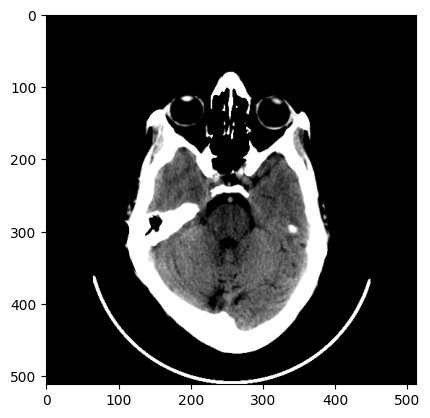

In [258]:
plt.imshow(windowed_scan[20,2].numpy(), cmap="gray")

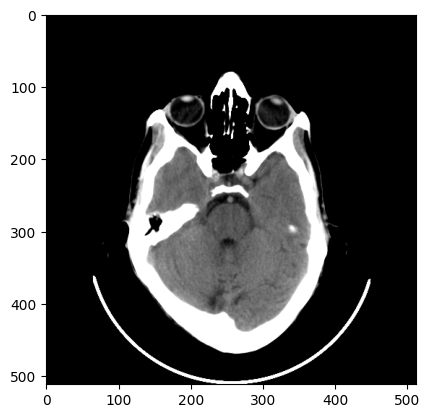

In [180]:
from qtrain.utils.defaults import brain_window
plt.imshow(brain_window(arr[20]), cmap="gray")

In [168]:
len(a)

5

In [289]:
a[0][35][0][100:, 100:].numpy() == a[0][35][2][100:, 100:].numpy()

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False]])

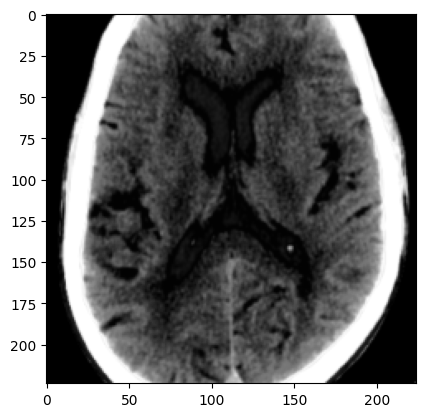

In [283]:
import matplotlib.pyplot as plt
plt.imshow(a[0][35][1].numpy(), cmap="gray")

In [9]:
df.loc[0, "annotpath"] != "None"

False

In [ ]:
df = df.drop(45988)
df = df.reset_index(drop=True)
failed = []
from safetensors import safe_open
for i in tqdm(range(45987, len(df))):
    try:
        with safe_open(df.loc[i, "filepath"], framework="pt", device="cpu") as f:
            for k in f.keys():
                annotation = f.get_tensor(k).numpy()
        if df.loc[i, "annotpath"] != "None":
            with safe_open(df.loc[i, "annotpath"], framework="pt", device="cpu") as f:
                for k in f.keys():
                    annotation = f.get_tensor(k).numpy()
    except:
        failed.append(i)

  0%|          | 0/16233 [00:00<?, ?it/s]

In [ ]:
len(failed)

In [ ]:
failed = []
for i in tqdm(range(len(dataset))):
    try:
        ct, gt_segmentation_map, trg_cls, infarct_cls, series = dataset[i]
        print(series)
    except:
        failed.append(i)

  0%|          | 0/39615 [00:00<?, ?it/s]

1.2.840.113619.2.25.1.1761985627.1415345710.730
1.2.840.113619.2.81.290.1.3343.2.20131012.230725
1.2.840.113619.2.55.3.2831165733.49.1418099688.521
1.2.840.113619.2.278.3.2831165729.116.1443424107.217
1.2.840.113619.2.81.290.1.14454.3.20180922.230659
1.2.840.113619.2.278.3.2831165736.194.1351476293.488
1.2.840.113619.2.81.290.1.14659.2.20181118.295904
1.2.840.113619.2.284.3.2831165716.976.1411526508.473
1.2.840.113704.1.111.2932.1510875674.7
1.2.840.113619.2.22.315.1.645.2.20120711.273032
1.2.840.113619.2.415.3.2831170697.276.1539843304.394
1.2.840.113619.2.55.3.2831165735.648.1473124328.593
1.2.840.113619.2.55.3.2831165735.231.1422264046.796
1.2.840.113619.2.55.3.2831165733.713.1395887919.899
1.2.840.113619.2.55.3.2831165733.828.1492340908.470.7
1.2.840.113619.2.55.3.2831165736.344.1500291984.522
1.2.840.113619.2.55.3.2831165733.831.1385175421.339
1.2.840.113619.2.278.3.2831165733.773.1308705082.734
1.2.840.113619.2.55.3.2831165743.533.1403930534.669
1.2.840.113619.2.55.3.2831165733.9

1.2.840.113619.2.55.3.2831165733.548.1415244973.595
1.2.840.113619.2.55.3.2831165733.19.1416365185.826
1.2.840.113619.2.55.3.2831165733.101.1424662149.309
1.2.840.113619.2.284.3.2831168021.141.1345776369.389
1.2.840.113619.2.55.3.2831165733.125.1415687789.247
1.2.840.113619.2.278.3.2831165735.522.1344171881.408
1.2.840.113619.2.278.3.2831165733.297.1339281118.219
1.2.840.113619.2.22.288.1.26734.2.20181223.223212
1.2.840.113619.2.278.3.2831165729.897.1415710222.725
1.2.840.113619.2.55.3.2831165748.234.1408510055.510.4
1.2.840.113619.2.284.3.2831168021.146.1373939134.964
1.2.840.113704.1.111.5820.1497702583.17
1.2.840.113619.2.55.3.2831165735.493.1478658487.573
1.2.840.113619.2.415.3.168434711.374.1535454037.775
1.3.12.2.1107.5.1.4.54877.30000014110607210551500013179
1.2.840.113619.2.278.3.2831165733.684.1331517309.986
1.2.840.113619.2.278.3.2831165735.429.1327386690.768
1.2.840.113619.2.415.3.2831170697.400.1550577773.562
1.2.840.113619.2.278.3.2831165736.379.1336462859.476
1.2.840.1136

1.2.840.113619.2.55.3.2831165735.242.1459496125.842
1.2.840.113619.2.55.3.2831165733.945.1413782886.342
1.2.840.113619.2.55.3.2831165735.469.1461285809.422
1.2.840.113619.2.278.3.2831165743.392.1332394211.795
1.2.840.113619.2.55.3.2831165733.162.1508409393.660
1.2.840.113619.2.55.3.2831165733.955.1496808418.518
1.2.840.113619.2.278.3.2831165729.838.1485232967.642
1.2.840.113619.2.55.3.2831165736.687.1476126431.195
1.2.840.113619.2.55.3.2831165736.176.1413861771.772
1.2.840.113619.2.81.290.9005.12669.2.20181231.165851
1.2.840.113619.2.55.3.2831159060.675.1304040928.128
1.2.840.113619.2.55.3.2831165733.230.1427373785.48
1.2.840.113619.2.334.3.2831165721.845.1455583807.508
1.3.12.2.1107.5.1.4.84754.30000018102400592062500000526
1.2.840.113619.2.55.3.2831165752.515.1474359606.597.3
1.2.840.113619.2.81.290.26072.15170.2.20160721.245439
1.2.840.113619.2.81.290.1.911.2.20170309.110740
1.2.840.113619.2.415.3.2831170697.273.1546589750.234
1.2.840.113619.2.55.3.2831165733.867.1384742676.229
1.2.

1.2.840.113619.2.55.3.2831165721.887.1311645177.932
1.2.840.113619.2.55.3.2831165752.826.1511061800.529
1.2.840.113619.2.81.290.1.8791.2.20150423.241928
1.2.840.113619.2.55.3.2831165733.25.1424752041.595
1.2.840.113619.2.55.3.2831165756.398.1346730440.880
1.2.840.113619.2.278.3.2831165752.224.1347337755.253
1.3.12.2.1107.5.1.4.60438.30000012041103040642100001021
1.2.840.113619.2.81.290.1.240.2.20140616.225347
1.2.840.113619.2.81.290.9049.3055.2.20140526.262524
1.2.840.113619.2.22.288.1.26819.2.20190107.195255
1.2.840.113619.2.55.3.2831159060.707.1321672644.485
1.2.840.113619.2.278.3.2831165736.310.1336913904.903
1.2.840.113619.2.81.290.22002.7076.2.20121117.311331
1.2.840.113619.2.415.3.2831170697.796.1535265102.926
1.2.840.113619.2.278.3.2831165733.409.1361245226.112
1.3.12.2.1107.5.1.4.54877.30000013093006562164000000155
1.2.840.113619.2.55.3.2831165735.699.1476432233.914
1.2.840.113619.2.55.3.2831165733.81.1512894436.824
1.2.840.113619.2.278.3.2831165752.383.1349238566.641
1.2.840.1

1.3.12.2.1107.5.1.4.54877.30000013052003511398400013570
1.2.840.113619.2.278.3.2831165735.794.1339989362.25
1.2.840.113619.2.278.3.2831165733.311.1335500302.6
1.2.840.113619.2.415.3.2831168001.571.1535605057.517
1.2.840.113619.2.25.1.1761985627.1356228846.499
1.2.840.113619.2.278.3.2831165733.980.1342804315.257
1.2.840.113619.2.55.3.2831165735.699.1370204244.580
1.2.840.113619.2.55.3.2831165721.823.1313889029.33
1.2.840.113619.2.55.3.2831165748.875.1398573698.712.4
1.2.840.113619.2.278.3.2831165735.527.1358597971.245
1.2.840.113619.2.55.3.2831165735.807.1444149532.114
1.2.840.113619.2.55.3.2831165736.686.1471318454.835
1.2.840.113619.2.55.3.2831165733.986.1475297979.5.3
1.3.12.2.1107.5.1.4.54877.30000013092506322073400009942
1.3.12.2.1107.5.1.4.54877.30000014111707074614000006192
1.2.840.113619.2.55.3.2831165736.70.1476392211.276
1.2.840.113619.2.278.3.2831165736.375.1336072197.933
1.2.840.113619.2.278.3.2831165733.662.1330307930.598
1.2.840.113619.2.55.3.2831165748.221.1429498980.341


1.2.840.113619.2.55.3.2831165733.42.1377061250.334
1.2.840.113619.2.284.3.2831168021.336.1379559163.147
1.2.840.113619.2.55.3.2831165733.845.1385528600.621
1.2.840.113619.2.55.3.2831165743.303.1368854961.789
1.2.840.113619.2.278.3.2831165733.442.1360555077.717
1.3.12.2.1107.5.1.4.31395.30000019030414411270300000330
1.2.840.113619.2.55.3.2831165733.11.1387312878.100
1.2.840.113619.2.22.288.1.6285.2.20130927.210151
1.2.840.113619.2.55.3.2831165733.982.1412085984.608
1.2.840.113619.2.55.3.2831165736.177.1475476819.699
1.2.840.113619.2.81.290.1.17579.2.20181201.281413
1.2.840.113619.2.415.3.279733249.552.1545752486.4
1.2.840.113619.2.55.3.2831165733.415.1419529771.904
1.2.840.113619.2.55.3.2831175700.816.1538144893.810
1.2.840.113619.2.55.3.2831165733.71.1369771581.491
1.2.840.113619.2.22.288.1.4776.3.20120823.205540
1.2.840.113619.2.81.290.26072.13325.2.20151119.275031
1.2.840.113619.2.81.290.9059.418.2.20130504.273622
1.2.840.113619.2.278.3.2831165752.654.1333770072.920
1.2.840.113619.2.

1.2.840.113619.2.278.3.2831165729.731.1446740434.306
1.2.840.113619.2.278.3.2831165736.699.1343227625.457
1.2.840.113619.2.278.3.2831165733.380.1349642816.144
1.2.840.113704.1.111.2304.1505217382.10
1.2.840.113619.2.55.3.2831165733.212.1507381397.50
1.2.840.113619.2.278.3.2831165729.996.1469072661.399
1.2.840.113619.2.55.3.2831165736.762.1464643473.410
1.2.840.113619.2.334.3.2831165721.847.1508549441.994
1.2.840.113619.2.81.290.9049.1896.2.20140127.293135
1.2.840.113619.2.80.4200974903.5025.1546223162.1.4.1
1.2.840.113619.2.55.3.2831165735.251.1434033414.839
1.3.12.2.1107.5.1.4.60438.30000016080503334651700037685
1.2.840.113619.2.415.3.2831168001.985.1554690111.743
1.2.840.113619.2.80.1943794342.29968.1507579186.1.4.1
1.2.840.113619.2.55.3.2831165733.941.1475030902.983.3
1.2.840.113619.2.278.3.2831165748.709.1365388376.66
1.2.840.113619.2.278.3.2831165733.972.1346983241.545
1.3.12.2.1107.5.1.4.54877.30000012121003304975000031127
1.2.840.113619.2.278.3.2831165733.977.1340677392.250
1.2.

1.3.12.2.1107.5.1.4.40158.4.0.476090167432773
1.2.840.113619.2.55.3.2831165733.248.1409153573.123
1.2.840.113619.2.278.3.2831165736.700.1348739404.757
1.2.840.113619.2.55.3.2831165733.59.1379243787.910
1.2.840.113619.2.278.3.2831165735.651.1322551858.178
1.2.840.113619.2.55.3.2831165756.660.1419043929.397
1.2.840.113619.2.55.3.2831165743.893.1496113414.656
1.2.840.113619.2.278.3.2831165742.661.1323054451.912
1.2.840.113619.2.278.3.2831165735.527.1358597969.347
1.2.840.113619.2.55.3.2831165733.820.1372384842.329
1.2.840.113619.2.22.288.1.4006.2.20120128.192204
1.2.840.113619.2.81.290.1.1973.2.20130417.223621
1.2.840.113619.2.415.3.2831160596.252.1546906468.405
1.2.840.113619.2.55.3.2831165736.118.1407882685.819
1.2.840.113619.2.55.3.2831165733.558.1415609925.195
1.2.840.113619.2.81.325.1.7024.3.20181230.190018
1.2.840.113619.2.278.3.2831165736.306.1353288117.641
1.3.12.2.1107.5.1.4.60438.30000015042602475389000009216
1.2.840.113619.2.55.3.2831165735.232.1386482842.343
1.2.840.113619.2.5

1.2.840.113619.2.278.3.2831165736.7.1343222211.390
1.2.840.113619.2.81.290.26072.4904.2.20121122.263141
1.2.840.113619.2.415.3.2831198228.420.1547015098.963
1.2.840.113619.2.55.3.2831165735.173.1406720805.386
1.2.840.113619.2.278.3.2831165735.882.1328676945.607
1.2.840.113619.2.334.3.2831165716.375.1448247271.995
1.2.840.113619.2.284.3.2831166742.443.1405221635.439
1.2.840.113619.2.55.3.2831165733.62.1497955369.370
1.3.12.2.1107.5.1.4.31128.30000015031416265914000000459
1.2.840.113619.2.55.3.2831165756.809.1380254585.655
1.2.840.113619.2.334.3.2831165719.985.1495073927.74
1.2.840.113619.2.278.3.2831165733.140.1299468783.791
1.2.840.113619.2.55.3.2831165736.7.1415075086.588
1.2.840.113619.2.278.3.2831165736.260.1356401095.981
1.2.840.113619.2.334.3.2831165721.181.1430186875.219
1.2.840.113619.2.334.3.2831168021.666.1504666228.203
1.2.840.113619.2.55.3.2831165748.732.1376536222.500
1.3.12.2.1107.5.1.4.60438.30000016022905311252900011825
1.2.840.113619.2.415.3.168478488.592.1540544354.808

1.2.840.113619.2.81.290.9163.2722.2.20130417.221337
1.2.840.113619.2.284.3.2831165716.377.1408586152.396
1.2.840.113619.2.81.290.9059.836.2.20130723.202250
1.2.840.113619.2.284.3.2831166742.972.1424832458.298.4
1.2.840.113619.2.55.3.2831165733.451.1423846049.68
1.2.840.113619.2.55.3.2831165735.11.1421816029.859
1.2.840.113619.2.278.3.2831165729.144.1469294800.716
1.2.840.113619.2.81.290.1.3902.2.20170619.214731
1.2.840.113619.2.55.3.2831165748.812.1427611828.655
1.2.840.113619.2.55.3.2831165733.378.1430153572.856
1.2.840.113619.2.81.290.26072.9300.2.20141012.224545
1.2.840.113619.2.415.3.2831168001.704.1543459249.644
1.2.840.113704.1.111.6508.1470116992.10
1.2.840.113619.2.334.3.2831165716.250.1453430610.65
1.2.840.113619.2.81.290.9163.6410.2.20140628.201024
1.2.840.113619.2.284.3.2831165719.224.1398742941.542.3
1.2.840.113619.2.55.3.2831165742.948.1447381663.902
1.2.840.113619.2.284.3.2831165719.590.1411960767.889.3
1.2.840.113619.2.55.3.2831165735.187.1467959659.926
1.2.840.113619.2.

1.2.840.113619.2.25.1.1761985627.1338329288.393
1.2.840.113619.2.55.3.2831165736.227.1379043827.531
1.2.840.113619.2.334.3.2831165721.146.1388019833.68
1.2.840.113619.2.81.290.1.285.2.20140624.300454
1.2.840.113619.2.55.3.2831165743.777.1502678411.304
1.2.840.113619.2.80.4200974903.19464.1539995291.1.4.1
1.2.840.113619.2.334.3.2831166742.594.1498530575.608
1.2.840.113619.2.81.290.9059.5640.2.20150220.221012
1.2.840.113619.2.415.3.2831176961.129.1553566820.835
1.2.840.113619.2.55.3.2831165735.195.1400077127.246
1.2.840.113619.2.22.287.1.29685.3.20181121.211233
1.3.12.2.1107.5.1.4.98828.30000018110103102001000001220
1.2.840.113619.2.415.3.3233813952.563.1539075692.44
1.2.840.113619.2.55.3.2831165733.830.1390345767.926
1.3.12.2.1107.5.1.4.54877.30000012090107134417100013838
1.2.840.113619.2.55.3.2831165733.293.1434144831.677
1.2.840.113619.2.55.3.2831165733.953.1477885395.662
1.2.840.113619.2.284.3.2831166742.397.1347329835.560
1.2.840.113619.2.55.3.2831165733.162.1508409405.740
1.2.840.1

1.2.840.113619.2.278.3.2831165729.70.1492319036.264
1.2.840.113704.1.111.8396.1473486481.10
1.2.840.113619.2.278.3.2831165729.389.1423903158.607
1.2.840.113619.2.55.3.2831165735.493.1478658487.431
1.2.840.113619.2.55.3.2831165756.994.1421895881.351
1.2.840.113619.2.55.3.2831165735.794.1440423956.970
1.2.840.113619.2.284.3.2831168021.778.1386120004.433
1.2.840.113619.2.55.3.2831165733.853.1380768012.674
1.2.840.113619.2.284.3.2831166742.121.1422411472.855.4
1.3.12.2.1107.5.1.4.60438.30000014021803514310900014852
1.2.840.113619.2.22.288.1.6834.2.20141117.211538
1.2.840.113619.2.55.3.2831165736.95.1407981555.305
1.2.840.113619.2.55.3.2831165735.336.1449579993.699
1.2.840.113619.2.55.3.2831165721.831.1305075521.197
1.2.840.113619.2.415.3.168478488.611.1554645024.161
1.2.840.113619.2.81.290.1.982.102.20150218.302831
1.2.840.113619.2.415.3.2831165846.801.1496203953.560
1.2.840.113619.2.278.3.2831165736.938.1356719708.994
1.2.840.113619.2.55.3.2831165733.585.1386857783.890
1.2.840.113619.2.80

1.2.840.113619.2.81.290.26072.5911.6.20130218.300300
1.2.840.113619.2.55.3.2831165733.984.1403060113.491
1.2.840.113619.2.55.3.2831165733.162.1508409362.955
1.2.840.113619.2.278.3.2831165733.149.1341400142.407
1.2.840.113619.2.55.3.2831165735.333.1386705549.304
1.2.840.113619.2.55.3.2831165735.167.1407929678.133
1.2.840.113619.2.55.3.2831165735.187.1467959659.643
1.2.840.113619.2.81.290.9163.4406.2.20131005.224542
1.2.840.113619.2.284.3.2831166742.594.1408416397.898
1.2.840.113619.2.55.3.2831165721.585.1322710049.863
1.2.840.113619.2.55.3.2831165752.609.1513328031.849
1.2.840.113619.2.55.3.2831165748.594.1443240149.258.4
1.2.840.113619.2.415.3.2831168001.612.1545791010.147
1.2.840.113619.2.81.290.1.561.5.20140815.295942
1.2.840.113619.2.278.3.2831165733.479.1334150350.356
1.2.840.113619.2.55.3.2831165733.807.1429416112.817
1.2.840.113619.2.334.3.2831165721.974.1408416266.784
1.2.840.113619.2.81.290.1.39546.2.20190108.263034
1.2.840.113619.2.100.3.2831165756.706.1468114447.741.3
1.2.840

1.2.840.113619.2.332.3.2831165777.281.1440377733.887.4
1.2.840.113619.2.278.3.2831165736.61.1338870295.688
1.2.840.113619.2.81.290.9049.2695.3.20141023.262728
1.2.840.113619.2.55.3.2831165733.955.1496808367.73
1.2.840.113619.2.81.290.1.244.2.20130622.242711
1.3.12.2.1107.5.1.4.54877.30000012050904225665600003862
1.2.840.113619.2.55.3.2831165733.279.1417403547.460
1.2.840.113619.2.80.1943794342.23401.1406720573.32.4.1
1.2.840.113619.2.81.290.1.15852.2.20180820.205442
1.2.840.113619.2.55.3.2831165736.828.1469655069.453
1.2.840.113619.2.55.3.2831165733.471.1401414425.921
1.2.840.113619.2.55.3.2831165736.903.1406092549.515
1.2.840.113619.2.81.290.9163.10283.2.20170518.261519
1.2.840.113619.2.81.290.1.15419.2.20180723.240859
1.2.840.113704.1.111.6516.1477897651.7
1.2.840.113619.2.55.3.2831165756.811.1379648769.273
1.2.840.113619.2.278.3.2831165736.907.1343015373.921
1.2.840.113619.2.55.3.2831165736.508.1514029613.332
1.2.840.113619.2.100.3.2831165846.377.1473051510.567.3
1.2.840.113619.2.55

1.2.840.113619.2.55.3.2831165733.191.1391141018.984
1.2.840.113619.2.415.3.279733249.580.1554987495.762
1.2.840.113619.2.55.3.2831165736.278.1383529162.596
1.2.840.113619.2.80.1943474904.3253.1512569226.1.4.1
1.2.840.113619.2.55.3.2831165733.162.1508409350.88
1.2.840.113619.2.100.3.2831165756.152.1457318233.582.3
1.2.840.113619.2.55.3.2831168021.311.1299554216.676
1.2.840.113619.2.278.3.2831165735.794.1343619013.68
1.2.840.113619.2.278.3.2831165736.459.1340245418.843
1.2.840.113619.2.278.3.2831165733.837.1333485510.154
1.2.840.113619.2.81.290.1.7884.3.20170509.222011
1.2.840.113619.2.55.3.2831165733.193.1426384383.700
1.2.840.113619.2.415.3.3233813952.366.1540026009.772
1.2.840.113619.2.81.290.1.525.2.20141012.282352
1.2.840.113619.2.278.3.2831165736.152.1338699285.8
1.2.840.113619.2.278.3.2831165733.807.1324842731.899
1.2.840.113619.2.55.3.2831165742.137.1379572061.870
1.2.840.113619.2.55.3.2831165736.212.1392252691.775
1.2.840.113619.2.55.3.2831175700.515.1540738488.292
1.2.840.11361

1.2.840.113619.2.55.3.2831165748.846.1424315102.706.4
1.2.840.113619.2.55.3.2831165733.6.1493698803.8
1.2.840.113704.1.111.8668.1470839490.10
1.2.840.113619.2.278.3.2831165735.527.1358597973.20.3
1.2.840.113619.2.55.3.2831165733.257.1418536426.59
1.2.840.113619.2.55.3.2831165733.677.1383015477.632
1.2.840.113619.2.332.3.2831165777.296.1407980159.176.4
1.2.840.113619.2.334.3.2831166742.589.1503541711.191
1.2.840.113619.2.55.3.2831165736.166.1373935374.312
1.3.12.2.1107.5.1.4.44046.30000018090105042757800000034
1.2.840.113619.2.55.3.2831165733.849.1411210242.170
1.3.12.2.1107.5.1.4.24551.4.0.861700523462223
1.2.840.113619.2.278.3.2831165733.863.1342836941.666
1.3.12.2.1107.5.1.4.90897.30000018083104134255900000026
1.2.840.113619.2.55.3.2831165736.987.1371517161.961
1.2.840.113619.2.55.3.2831159060.586.1311824660.480
1.2.840.113619.2.55.3.2831165736.903.1411970421.240
1.2.840.113619.2.55.3.2831165735.958.1473895873.811
1.2.840.113704.1.111.5492.1472315024.10
1.2.840.113619.2.55.3.28311657

1.2.840.113619.2.22.287.144.14982.2.20181118.151122
1.2.840.113619.2.284.3.2831166742.532.1386647403.989
1.2.840.113619.2.81.290.9059.2740.2.20140623.302012
1.2.840.113619.2.22.288.1.5236.3.20121220.232130
1.2.840.113619.2.334.3.2831165756.261.1440995191.918
1.2.840.113619.2.415.3.3233859776.181.1532704426.520
1.2.840.113619.2.81.290.22002.9384.2.20130602.230741
1.2.840.113619.2.55.3.2831165735.718.1475328930.856
1.2.840.113619.2.55.3.2831165735.319.1421897529.744
1.2.840.113619.2.55.3.2831165736.594.1475293290.783
1.2.840.113619.2.55.3.2831165756.59.1370494683.683
1.3.12.2.1107.5.1.4.40318.4.0.3223126321692234
1.2.840.113619.2.81.290.22002.6254.2.20120827.263459
1.2.840.113619.2.55.3.2831165735.582.1425117029.224
1.2.840.113619.2.278.3.2831165733.747.1363114133.948
1.2.840.113619.2.55.3.2831165733.995.1512392116.886.7
1.3.12.2.1107.5.1.4.34169.4.0.5452583879533131
1.2.840.113619.2.415.3.3233859776.439.1534523213.556
1.2.840.113619.2.55.3.2831165756.464.1364701672.707
1.2.840.113619.2.

1.2.840.113619.2.55.3.2831165735.469.1472608972.796
1.3.12.2.1107.5.1.4.40158.4.0.8999665119112423
1.2.840.113619.2.415.3.3233813952.216.1544154656.878
1.3.12.2.1107.5.1.4.31395.30000019031011010204600000149
1.2.840.113619.2.55.3.2831165733.107.1475641253.593.3
1.2.840.113619.2.278.3.2831165729.843.1439666966.20
1.2.840.113619.2.22.288.1.6314.2.20131009.241713
1.2.840.113619.2.55.3.2831165733.184.1507880026.618
1.2.840.113619.2.278.3.2831165733.140.1299468783.837
1.2.840.113619.2.81.290.9059.6640.2.20150428.234639
1.2.840.113619.2.55.3.2831159060.515.1321934047.73
1.2.840.113619.2.55.3.2831165735.802.1513819617.695
1.2.840.113619.2.55.3.2831165733.266.1481198308.252.3
1.2.840.113619.2.81.290.1.4166.2.20130416.230937
1.2.840.113619.2.55.3.2831165735.348.1466718465.380
1.2.840.113619.2.278.3.2831165736.755.1346382941.607
1.2.840.113619.2.55.3.2831165733.107.1509154506.279
1.2.840.113619.2.55.3.2831165736.397.1508641241.490
1.2.840.113619.2.81.290.1.3756.2.20150218.280834
1.2.840.113619.2

1.2.840.113619.2.284.3.2831168021.707.1414117652.535
1.2.840.113619.2.55.3.2831165733.82.1367637505.803
1.2.840.113619.2.81.290.9059.6677.2.20150430.310048
1.3.12.2.1107.5.1.4.31128.30000017112207050450000000778
1.3.12.2.1107.5.1.4.54877.30000012061203301785900005682
1.2.840.113619.2.81.290.9059.3866.2.20140929.240635
1.3.12.2.1107.5.1.4.44046.30000018101707593282800000004
1.2.840.113619.2.55.3.2831165752.345.1473729835.178
1.2.840.113619.2.55.3.2831165733.802.1389926160.502
1.2.840.113619.2.81.290.22002.8078.2.20130211.221459
1.2.840.113619.2.284.3.2831166742.65.1385264388.270
1.2.840.113619.2.284.3.2831166742.982.1419473914.331
1.2.840.113619.2.55.3.2831165736.611.1472953536.619
1.2.840.113619.2.55.3.2831165733.91.1415244197.879
1.2.840.113619.2.55.3.2831165748.235.1374057098.413.4
1.2.840.113619.2.278.3.2831165736.152.1337234203.557
1.2.840.113619.2.284.3.2831166742.467.1334371623.795
1.2.840.113704.1.111.10416.1483337177.7
1.2.840.113619.2.55.3.2831165736.73.1512096157.35
1.2.840.1

1.2.840.113619.2.55.3.2831165733.772.1380999227.756
1.2.840.113619.2.81.325.1.6475.2.20180911.101041
1.3.12.2.1107.5.1.4.34169.4.0.7178635824833254
1.2.840.113619.2.80.1943794342.22427.1507168896.32.4.1
1.2.840.113619.2.55.3.2831165733.681.1374901373.907
1.3.12.2.1107.5.1.4.60438.30000014110809412771800007865
1.2.840.113619.2.55.3.2831165733.35.1406517224.448
1.2.840.113619.2.415.3.3233813952.114.1546152228.206
1.2.840.113619.2.278.3.2831165736.868.1354432357.481
1.2.840.113619.2.278.3.2831165733.524.1349130340.507
1.2.840.113619.2.278.3.2831165729.731.1446740455.333
1.2.840.113619.2.55.3.2831165735.833.1383886521.554
1.2.840.113619.2.55.3.2831165736.138.1416042600.391
1.2.840.113619.2.332.3.2831168304.256.1396064622.398.3
1.2.840.113619.2.55.3.2831165735.822.1470208875.362
1.2.840.113619.2.55.3.2831165733.173.1374982285.878
1.3.12.2.1107.5.1.4.31128.30000011102203541404600000647
1.2.840.113619.2.334.3.2831165716.172.1442285128.134
1.2.840.113619.2.55.3.2831165736.762.1461698058.22
1.2

1.2.840.113619.2.55.3.2831165752.244.1459476767.989
1.2.840.113619.2.55.3.2831165735.212.1511108103.731
1.2.840.113619.2.55.3.2831165735.802.1513819619.542
1.2.840.113619.2.55.3.2831165736.996.1409111303.996
1.2.840.113619.2.55.3.2831165735.894.1463662342.442
1.2.840.113619.2.334.3.2831165721.709.1504494522.774
1.2.840.113619.2.55.3.2831165736.620.1464231575.993
1.2.840.113619.2.55.3.2831165735.602.1416561491.601
1.2.840.113619.2.284.3.2831168021.222.1411792462.562
1.3.12.2.1107.5.1.4.31128.30000015062403322473400001423
1.2.840.113619.2.55.3.2831165733.88.1509856777.651
1.2.840.113619.2.55.3.2831165743.780.1510191309.683
1.2.840.113619.2.278.3.2831165736.173.1355159258.838
1.2.840.113619.2.55.3.2831165743.877.1418446212.950
1.2.840.113619.2.284.3.2831168021.240.1351910678.634
1.2.840.113619.2.81.290.1.266.2.20130602.212141
1.2.840.113619.2.284.3.2831168021.36.1342576494.79
1.2.840.113619.2.55.3.2831165752.772.1474971070.404
1.2.840.113619.2.278.3.2831165752.587.1332733567.602
1.2.840.1

1.2.840.113619.2.55.3.2831165736.32.1409188071.923
1.2.840.113619.2.55.3.2831165743.70.1408444918.824
1.2.840.113619.2.415.3.279733249.444.1546713013.840
1.2.840.113619.2.55.3.2831165733.894.1370492595.419
1.2.840.113619.2.81.290.1.3135.2.20170919.292710
1.2.840.113619.2.55.3.2831165742.88.1421120787.971
1.2.840.113619.2.22.288.8111.21284.2.20190114.243801
1.2.840.113619.2.55.3.2831159060.335.1302055054.850
1.2.840.113619.2.278.3.2831165748.112.1357094814.927
1.2.840.113619.2.284.3.2831165719.928.1386994290.240
1.2.840.113619.2.55.3.2831165752.277.1432377288.825
1.2.840.113619.2.278.3.2831165736.869.1309093987.799
1.2.840.113619.2.278.3.2831165733.344.1333169226.627
1.2.840.113704.1.111.5240.1509693542.7
1.2.840.113619.2.417.3.2831209472.886.1555891448.12
1.2.840.113619.2.284.3.2831166742.126.1383538775.572
1.2.840.113619.2.55.3.2831165733.113.1391141546.189
1.2.840.113619.2.278.3.2831165733.762.1301879607.698
1.2.840.113619.2.278.3.2831165733.197.1329105134.377
1.2.840.113619.2.55.3.2

1.2.840.113619.2.22.288.1.5336.2.20130121.195206
1.2.840.113619.2.415.3.2831176961.898.1532575534.69
1.2.840.113619.2.415.3.2831160596.26.1546655632.4
1.2.840.113619.2.55.3.2831165733.728.1372124098.250
1.2.840.113619.2.284.3.2831166742.674.1407987333.918
1.2.840.113619.2.415.3.3233813952.335.1539609494.493
1.2.840.113619.2.22.287.1.29028.2.20180808.263401
1.2.840.113619.2.81.290.1.5755.2.20141114.245940
1.2.840.113619.2.284.3.2831166742.960.1392864635.152
1.2.840.113619.2.284.3.2831165716.55.1371265238.396.3
1.2.840.113619.2.55.3.2831165736.985.1408433731.399
1.2.840.113619.2.278.3.2831165733.151.1304488115.822
1.2.840.113619.2.55.3.2831165735.395.1469590531.492
1.2.840.113619.2.55.3.2831165736.132.1413510885.121
1.2.840.113619.2.55.3.2831165733.212.1507381401.474
1.2.840.113619.2.55.3.2831165736.424.1508436373.238
1.2.840.113704.1.111.7728.1493015072.6
1.2.840.113619.2.55.3.2831165733.883.1386208304.457
1.2.840.113619.2.284.3.2831168021.721.1381977239.751
1.2.840.113619.2.278.3.28311

1.2.840.113619.2.55.3.2831165752.785.1464441263.963
1.2.840.113619.2.55.3.2831165733.154.1408684726.357
1.2.840.113619.2.55.3.2831175700.983.1542617855.529
1.2.840.113619.2.278.3.2831165733.452.1360117809.835
1.2.840.113619.2.55.3.2831165752.989.1449562314.216
1.2.840.113619.2.55.3.2831165742.271.1500950062.617
1.2.840.113619.2.100.3.2831165756.926.1470982536.905.3
1.2.840.113619.2.80.1943373230.27396.1500480084.1.4.1
1.2.840.113619.2.278.3.2831165752.165.1354325985.258
1.2.840.113619.2.415.3.2831165786.829.1512704119.196
1.2.840.113619.2.55.3.2831165735.446.1469332569.134
1.2.840.113619.2.55.3.2831165748.812.1400725524.101
1.2.840.113619.2.55.3.2831165733.669.1377658142.936
1.2.840.113619.2.55.3.2831165752.390.1474617475.105
1.2.840.113619.2.278.3.2831165735.439.1337560633.307
1.2.840.113619.2.278.3.2831165733.885.1343442014.762
1.2.840.113619.2.278.3.2831165736.622.1370130945.96
1.2.840.113619.2.55.3.2831165735.521.1513151114.255
1.2.840.113619.2.55.3.2831165748.955.1484807340.222
1.

1.2.840.113619.2.55.3.2831165721.583.1314767581.68
1.2.840.113619.2.81.290.1.945.2.20131016.241933
1.2.840.113619.2.81.325.1.7448.2.20190404.331352
1.2.840.113619.2.22.288.1.5560.2.20130313.234805
1.2.840.113619.2.22.288.1.6347.2.20131022.222815
1.2.840.113619.2.55.3.2831165733.807.1429416113.133
1.2.840.113619.2.278.3.2831165733.913.1331952287.302
1.2.840.113619.2.55.3.2831165748.914.1390617734.877.4
1.2.840.113619.2.55.3.2831165743.277.1400557138.761
1.2.840.113619.2.81.290.1.4194.2.20170729.272010
1.2.840.113619.2.284.3.2831168021.89.1392253288.566
1.2.840.113619.2.334.3.2831165719.694.1500345463.14
1.2.840.113619.2.55.3.2831165748.835.1437965786.464.4
1.2.840.113619.2.100.3.2831165756.858.1460260627.260.3
1.2.840.113619.2.55.3.2831165735.243.1422081598.679
1.2.840.113619.2.81.290.9163.1465.2.20121126.220700
1.2.840.113619.2.55.3.2831165748.950.1507434191.147
1.2.840.113619.2.55.3.2831165736.851.1377132531.480
1.2.840.113619.2.81.290.9059.1461.2.20131028.220924
1.2.840.113619.2.55.3

1.2.840.113619.2.278.3.2831165736.995.1344740837.998
1.2.840.113619.2.22.315.1.1123.2.20130717.273211
1.2.840.113619.2.278.3.2831165736.641.1351204615.989
1.2.840.113619.2.284.3.2831165716.424.1340762593.114.3
1.2.840.113619.2.55.3.2831165736.597.1474961891.736
1.2.840.113619.2.55.3.2831165736.425.1508216202.377
1.2.840.113619.2.334.3.2831168021.218.1506394541.667
1.2.840.113619.2.278.3.2831165752.3.1363407906.775
1.2.840.113619.2.55.3.2831165721.137.1351388826.694
1.2.840.113619.2.55.3.2831165736.271.1387330803.539
1.2.840.113619.2.55.3.2831165736.559.1511466938.939
1.2.840.113619.2.81.290.1.9254.3.20150521.275431
1.2.840.113619.2.55.3.2831165748.940.1444186633.550.4
1.2.840.113619.2.55.3.2831165756.404.1383018578.879
1.2.840.113619.2.55.3.2831165733.828.1492340860.322
1.2.840.113619.2.278.3.2831165733.108.1329965216.322
1.2.840.113619.2.55.3.2831165721.91.1310450069.33
1.2.840.113619.2.80.1943794342.1306.1511290182.1.4.1
1.2.840.113619.2.334.3.2831165719.154.1504061779.814
1.2.840.11

1.2.840.113619.2.55.3.2831165736.270.1397441903.462
1.2.840.113619.2.55.3.2831165743.782.1494815979.65
1.2.840.113619.2.278.3.2831165729.305.1417496164.932
1.2.840.113619.2.55.3.2831165733.897.1394671299.661
1.2.840.113619.2.55.3.2831165735.864.1439615825.957
1.3.12.2.1107.5.1.4.31128.30000017061601483014000001838
1.2.840.113619.2.55.3.2831165748.791.1369966885.221.4
1.2.840.113619.2.81.290.1.890.2.20141211.334056
1.3.12.2.1107.5.1.4.40318.4.0.2372133816933805
1.2.840.113619.2.55.3.2831165735.395.1469590523.252
1.2.840.113619.2.81.290.1.14689.4.20181124.243818
1.2.840.113619.2.55.3.2831165752.320.1423978962.181
1.2.840.113619.2.55.3.2831165735.199.1466401826.279
1.2.840.113619.2.284.3.2831168021.218.1348629828.371
1.2.840.113619.2.55.3.2831165721.20.1304212568.101
1.2.840.113619.2.55.3.2831165748.814.1414039199.133.4
1.2.840.113619.2.55.3.2831165736.879.1412144444.908
1.2.840.113619.2.415.3.279733249.531.1555596776.127
1.2.840.113619.2.81.290.22002.11356.2.20131027.304101
1.2.840.11361

In [148]:
args_yaml.encoder_name

'resnet34'

In [43]:
import torch, torchmetrics as tm

In [48]:
torch.nan

nan

In [58]:
tm.StatScores(task="binary", ignore_index=-100, average='none', validate_args=False)(torch.tensor([0.5,0.3,0.4, 0.1]), torch.tensor([-100,-100,-100, -100]))


tensor([0, 0, 0, 0, 0])

In [ ]:
smp.losses.JaccardLoss(mode="binary", ignore_index=-100, 

In [ ]:
torch.tensor([0.5,0.3,0.4,0.1,0.1]), torch.tensor([-100,-100,-100,-100,0])

In [245]:
SMOOTH = 1e-6

def mean_iou_ignore_idx(predictions, targets, ignore_index=-100):
    valid_mask = targets != ignore_index
    idx = torch.where(valid_mask.sum(axis=(1,2))>0)

    intersection = (predictions[idx] &  targets[idx]).sum(dim=(1,2))
    union = (predictions[idx] | targets[idx]).sum(dim=(1,2))

    iou = (intersection.float() / union.float())
    return iou

In [224]:
iou = tm.JaccardIndex(task="binary", ignore_index=-100, validate_args=False, average='none')

In [225]:
gt = torch.vstack([F.softmax(torch.randn((2, 64, 2, 224, 224))).argmax(2), torch.zeros((2, 64, 224, 224))*-100, torch.ones((2, 64, 224, 224)) * -100]).to(torch.int16)
pred = F.softmax(torch.randn(6, 64, 2, 224, 224)).argmax(2)
gt[gt.sum(axis=(2,3))<=0] = -100

/tmp/ipykernel_643132/1814205740.py:1: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/tmp/ipykernel_643132/1814205740.py:2: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



In [227]:
gt.shape, pred.view(-1, *pred.size()[2:]).shape

(torch.Size([6, 64, 224, 224]), torch.Size([384, 224, 224]))

In [246]:
b = mean_iou_ignore_idx(pred.view(-1, *pred.size()[2:])>=0.5, gt.view(-1, *gt.size()[2:]), ignore_index=-100)
b

<class 'torch.Tensor'>


tensor([0.3316, 0.3317, 0.3332, 0.3328, 0.3300, 0.3329, 0.3318, 0.3276, 0.3324,
        0.3287, 0.3368, 0.3308, 0.3336, 0.3325, 0.3273, 0.3349, 0.3335, 0.3323,
        0.3336, 0.3355, 0.3310, 0.3323, 0.3314, 0.3303, 0.3313, 0.3337, 0.3288,
        0.3319, 0.3326, 0.3328, 0.3288, 0.3349, 0.3377, 0.3387, 0.3363, 0.3328,
        0.3362, 0.3307, 0.3326, 0.3314, 0.3353, 0.3321, 0.3311, 0.3341, 0.3351,
        0.3362, 0.3304, 0.3345, 0.3369, 0.3303, 0.3325, 0.3367, 0.3331, 0.3287,
        0.3329, 0.3351, 0.3314, 0.3353, 0.3353, 0.3362, 0.3346, 0.3313, 0.3310,
        0.3292, 0.3329, 0.3292, 0.3324, 0.3349, 0.3318, 0.3315, 0.3348, 0.3334,
        0.3346, 0.3349, 0.3329, 0.3363, 0.3325, 0.3291, 0.3287, 0.3362, 0.3352,
        0.3333, 0.3303, 0.3298, 0.3334, 0.3293, 0.3308, 0.3327, 0.3375, 0.3365,
        0.3393, 0.3288, 0.3387, 0.3349, 0.3330, 0.3345, 0.3339, 0.3342, 0.3335,
        0.3321, 0.3334, 0.3350, 0.3360, 0.3355, 0.3320, 0.3328, 0.3275, 0.3359,
        0.3309, 0.3360, 0.3338, 0.3326, 

In [209]:
torch.mean(b)

tensor(0.3337)

In [98]:
valid_mask = gt != -100
pred = predictions[valid_mask]
targets = targets[valid_mask]

RuntimeError: "bitwise_and_cpu" not implemented for 'Float'

In [68]:
tm.JaccardIndex(task="binary", ignore_index=-100, validate_args=False, average='none')(torch.tensor([[0.5,0.3,0.4,0.1,0.1], [0.5,0.3,0.4,0.1,0.1]]), torch.tensor([[-100,-100,-100,-100,-100], [-100,-100,-100,-100,-100]]))



tensor(nan)

In [161]:
miou = tm.classification.JaccardIndex(task="binary", num_classes=2, ignore_index=-100)
miou = tm.AveragePrecision(task="multiclass", num_classes=2, ignore_index=-100)
auc= tm.AUROC(task="binary", ignore_index=-100, validate_args=False, average='none')

In [165]:
gt = torch.stack([torch.ones((1, 224, 224)) * -100, torch.ones((2, 224, 224)) * -100]).to(torch.int16)

RuntimeError: stack expects each tensor to be equal size, but got [1, 224, 224] at entry 0 and [2, 224, 224] at entry 1

In [166]:
gt.shape

torch.Size([4, 64, 224, 224])

In [ ]:
target_score = [-100,-100]

In [164]:
auc(F.softmax(torch.randn(20,2)), torch.ones(20,2))

/tmp/ipykernel_643132/4063759301.py:1: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/users/ujjwal.upadhyay/miniconda3/envs/train/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning:

No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score



tensor(0.)

In [258]:
gt[gt>=0]

tensor([], dtype=torch.int16)

In [280]:
len(torch.ones((3, 224, 224))[gt>=0])

0

In [276]:
F.softmax(torch.randn((3, 3, 224, 224))).shape

/tmp/ipykernel_397008/1525637199.py:1: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



torch.Size([3, 3, 224, 224])

In [304]:
pred = F.softmax(torch.randn((2,64,2, 224, 224)))
pred = pred.view(-1, *pred.size()[2:])

/tmp/ipykernel_397008/654187088.py:1: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



In [306]:
pred.argmax(1)

tensor([[[0, 1, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 1, 1, 0],
         [1, 1, 1,  ..., 1, 0, 1],
         ...,
         [1, 0, 1,  ..., 0, 0, 1],
         [1, 1, 0,  ..., 1, 0, 0],
         [1, 1, 1,  ..., 1, 1, 0]],

        [[1, 0, 1,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 1, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 1, 1, 0],
         [0, 1, 0,  ..., 0, 1, 0],
         [0, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [0, 0, 1,  ..., 0, 1, 1],
         [1, 0, 1,  ..., 0, 0, 0],
         ...,
         [0, 1, 1,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 1],
         [1, 1, 1,  ..., 0, 1, 1]],

        ...,

        [[0, 1, 1,  ..., 0, 1, 1],
         [1, 1, 1,  ..., 0, 1, 0],
         [1, 0, 1,  ..., 0, 1, 1],
         ...,
         [0, 0, 1,  ..., 1, 0, 0],
         [1, 1, 1,  ..., 1, 0, 0],
         [1, 0, 1,  ..., 1, 0, 1]],

        [[1, 1, 1,  ..., 0, 1, 0],
         [1, 1, 1,  ..., 1, 1, 0],
         [1,

In [307]:
miou(
    pred,
    torch.ones(128,224,224).to(torch.int16),
)

tensor(1.)

In [41]:
gt = torch.vstack(
    [
        torch.ones((1, 224, 224)) * -100,
        torch.zeros((2, 224, 224)),
        torch.ones((2, 224, 224)),
    ]
)

In [159]:
a = defaultdict(list)

In [160]:
a.clear()

In [44]:
gt[gt.sum(axis=(1, 2)) <= 0] = -100

In [49]:
gt[0]

tensor([[-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        ...,
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.]])

In [ ]:
gt[gt.sum(axis=(2, 3)) <= 0] = self.ignore_index

In [46]:
gt = torch.tensor([-100, -100])
pred = torch.tensor([0.5, 0.5])
gt_ = gt[gt > 0]
pred[gt > 0]

tensor([])

In [52]:
torch.mean(
    torch.nn.BCEWithLogitsLoss(reduction="none")(pred.double(), gt.double()) * (gt > 0)
)

tensor(0., dtype=torch.float64)

In [59]:
torch.tensor([[[0.3, 0.2], [0.5, 0.3]]]), torch.tensor([[[-100, -100]]])

(torch.Size([1, 2, 2]), torch.Size([1, 1, 2]))

In [63]:
gt = torch.ones(120, 224, 224) * -100

In [95]:
gt = torch.vstack([torch.ones(60, 224, 224) * -100, torch.ones(60, 224, 224) * -100])

In [97]:
a = smp.losses.FocalLoss(mode="multiclass", ignore_index=-100, reduction="none")(
    torch.randn(120, 2, 224, 224), torch.ones_like(gt)
)
a

tensor([0.2328, 0.5071, 0.3637,  ..., 0.4482, 0.1661, 1.0009])

In [105]:
gt.flatten().shape

torch.Size([6021120])

In [106]:
torch.mean(a * (gt.flatten() >= 0))

tensor(0.)

In [107]:
torch.all(gt == -100)

tensor(True)

In [110]:
import torchmetrics as tm

miou = tm.JaccardIndex(task="binary", num_classes=2, ignore_index=-100, average="none")

In [114]:
torch.nn.functional.softmax(torch.randn(120, 2, 224, 224)).argmax(1).shape

/tmp/ipykernel_3421264/504142527.py:1: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



torch.Size([120, 224, 224])

In [116]:
miou(
    torch.nn.functional.softmax(torch.randn(120, 2, 224, 224)).argmax(1),
    torch.ones_like(gt),
)

/tmp/ipykernel_3421264/2407387451.py:1: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



tensor(0.5004)

In [85]:
gt.sum(axis=(0, 1, 2)).shape

torch.Size([])

In [81]:
a * (gt.sum(axis=(1, 2)) >= 0)

RuntimeError: The size of tensor a (6021120) must match the size of tensor b (120) at non-singleton dimension 0

In [60]:
smp.losses.FocalLoss(mode="multiclass", ignore_index=-100)(
    torch.tensor([[[0.3, 0.2], [0.5, 0.3]]]), torch.tensor([[[-100, -100]]])
)

IndexError: too many indices for tensor of dimension 2

In [44]:
(torch.tensor([-100, -100]) >= 0) * torch.nn.BCEWithLogitsLoss(reduction="none")(
    torch.tensor([0.5, 0.5])[torch.tensor([-100, -100]) >= 0].double(),
    torch.tensor([-100, -100])[torch.tensor([-100, -100]) >= 0].double(),
)

RuntimeError: The size of tensor a (2) must match the size of tensor b (0) at non-singleton dimension 0

tensor([50.9741, 50.9741], dtype=torch.float64)

In [99]:
b = torch.nan_to_num(b)
b

tensor([[[[[-9.1304e-01, -1.3708e+00,  1.1664e+00,  ...,  7.0140e-01,
            -7.9347e-02, -2.4437e+00],
           [-3.8923e+00,  2.4273e+00,  5.2375e-01,  ..., -2.3388e+00,
             3.4612e+00,  3.3114e+00],
           [ 3.3569e+00,  2.9452e-01,  8.8207e-01,  ..., -5.6504e-02,
            -2.9874e-01,  1.6887e+00],
           ...,
           [ 1.1366e+00,  1.4243e+00,  7.8247e-01,  ...,  2.0315e+00,
            -1.7737e+00, -7.4019e-01],
           [ 5.8112e+00, -1.2881e+00, -1.4819e+00,  ...,  9.4211e-01,
            -3.2278e-01,  1.1619e+00],
           [ 5.6657e-01, -1.5852e+00, -2.0359e+00,  ...,  1.5124e+00,
             2.5323e+00,  1.2553e+00]],

          [[-9.0239e-01,  1.8768e+00,  8.1895e-01,  ..., -1.7609e+00,
             1.1886e+00,  3.9934e+00],
           [-7.9912e-01,  2.8844e-01, -1.4142e+00,  ..., -2.1516e+00,
            -8.1035e-01, -7.3700e-01],
           [-1.8195e+00,  7.9811e-02, -1.8360e+00,  ...,  7.8954e-01,
             5.3233e+00,  2.4375e-01],
 

In [100]:
b.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

In [95]:
a = torch.randn(2, 64, 2, 224, 224)
a.requires_grad = True
a.shape

torch.Size([2, 64, 2, 224, 224])

In [91]:
F.softmax(torch.randn(2, 2))

/tmp/ipykernel_2235305/3538350211.py:1: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



tensor([[0.5836, 0.4164],
        [0.2924, 0.7076]])

In [85]:
a.view(-1, *a.size()[2:]).shape

torch.Size([128, 2, 224, 224])

In [15]:
args_yaml

Munch({'augmentation': True, 'background_index': 0, 'batch_size': 2, 'cls_loss_wts': Munch({'ce': 3}), 'crop': True, 'datapath': '/data_nas4/processed/qer/all_studies_10k.json', 'dataset_class': <class 'qtrain.dataset.infarct.InfarctDataset3D'>, 'dataset_module': <class 'qtrain.dataset.infarct.InfarctDataModule'>, 'dataset_type': '3D', 'extra_augs': False, 'fast_batch_size': 4, 'fast_dev_run': False, 'gpu': 2, 'img_size': 224, 'losses': Munch({'cls/bce': CrossEntropyLoss(), 'seg/dice': GDiceLossV2(), 'seg/focal': FocalLoss(), 'seg/mcc': MCCLoss()}), 'max_epoch': 300, 'mode': 'binary', 'model': <class 'qtrain.models.unet.unet2dseqattn.UnetSeqAttn'>, 'model_params': Munch({'attention_type': None, 'cls_dropout': 0.3, 'cls_nclasses': 2, 'cls_pooling': 'avg', 'decoder_channels': (128, 64, 32, 16), 'depth': 4, 'encoder_name': 'efficientnet-b6', 'in_channels': 3, 'kernel_size': 5, 'n_segmaps': 1, 'n_slices': 60, 'output_stride': 16, 'seg_activation': 'sigmoid', 'use_batchnorm': True}), 'model

In [26]:
dm = args_yaml.dataset_module(args_yaml)

In [27]:
loader = dm.train_dataloader()

train data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 45618.79it/s]

1008 scans present in train data belonging to 1 classes



In [28]:
dataset = args_yaml.dataset_class(args_yaml)

train data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 61649.46it/s]

1008 scans present in train data belonging to 1 classes



In [29]:
len(dataset)

1008

In [ ]:
index = i
target = pydicom.read_file(dataset.target[index]).pixel_array

In [ ]:
label_keys = list(dataset.labels[index].keys())
annotation = target

In [ ]:
annotation = np.where(np.isin(annotation, dataset.labels[index][label_keys[0]]), 1, 0)

In [ ]:
annotation.shape

In [ ]:
plt.imshow(annotation)

In [ ]:
plt.imshow(pydicom.read_file(dataset.target[0]).pixel_array)

In [50]:
a, b = dataset[i]

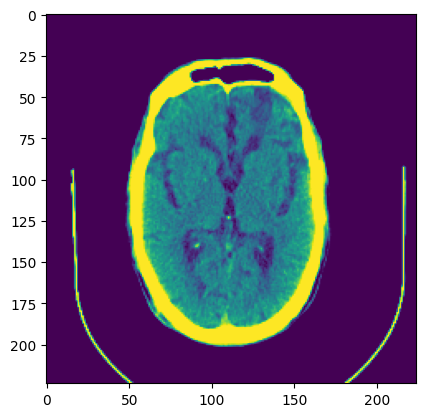

In [52]:
plt.imshow(a[0].numpy())

In [44]:
for i in tqdm(range(len(dataset))):
    a, b = dataset[i]
    if b.sum() > 0:
        break
#     print(a.shape, b.shape)

  0%|          | 0/30572 [00:00<?, ?it/s]

In [53]:
from qtrain.models.train_models import qSegmentation

In [55]:
a, b = next(iter(loader))

In [54]:
model = qSegmentation(args_yaml)

In [56]:
b_ = model(a)

In [62]:
args_yaml.losses

Munch({'dice_ce_loss': DiceCELoss(
  (dice): DiceLoss()
  (cross_entropy): CrossEntropyLoss()
), 'focal_loss': FocalLoss(), 'mse_loss': MSELoss()})

In [66]:
for key in args_yaml.losses:
    print(key, args_yaml.losses[key](b_["masks"], b))

dice_ce_loss tensor(0.9992, dtype=torch.float64, grad_fn=<AddBackward0>)
focal_loss tensor(0.4152, dtype=torch.float64, grad_fn=<MeanBackward0>)
mse_loss tensor(0.3394, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [22]:
from qtrain.sampler.weighted_sampling import WeightedRandomSampler

In [20]:
dataset = args_yaml.dataset_class(args_yaml)

train data: 100%|███████████████████████████████████████████████████████████████████| 1008/1008 [00:00<00:00, 7239.97it/s]

30572 slices present in train data.



In [24]:
from qtrain.sampler.weighted_sampling import WeightedRandomSampler

s = WeightedRandomSampler(dataset)

In [30]:
loader = DataLoader(
    dataset,
    batch_size=8,
    num_workers=8,
    drop_last=True,
    pin_memory=True,
    shuffle=False,
)

In [31]:
a, b = next(iter(loader))

In [32]:
a.shape, b.shape

(torch.Size([8, 3, 224, 224, 8]), torch.Size([8, 8, 224, 224]))

In [61]:
args.model_params

Munch({'resnet': 'seresnet50', 'attn_mode': 'softminmax'})

In [129]:
model = args.model(**args.model_params).double()

[2023-06-28 09:47:41 +0530] [INFO] Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnet50_ra_224-8efdb4bb.pth)
Total params: 28088024
(8, 224, 224)


In [130]:
out = model(a.reshape(8, 3, 8, 224, 224).double())

In [131]:
out[-1].shape

torch.Size([8, 8, 224, 224])

In [107]:
import torch.nn.functional as F

In [121]:
x = F.softmax(out[-1][1], dim=1)
x = F.interpolate(x, size=(8, 224, 224), mode="trilinear", align_corners=False)
print(x[:, 1].shape)

torch.Size([8, 8, 224, 224])


In [33]:
for i in range(b.shape[0]):
    print(b[i][0].sum())

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(9)
tensor(308)
tensor(0)
tensor(0)


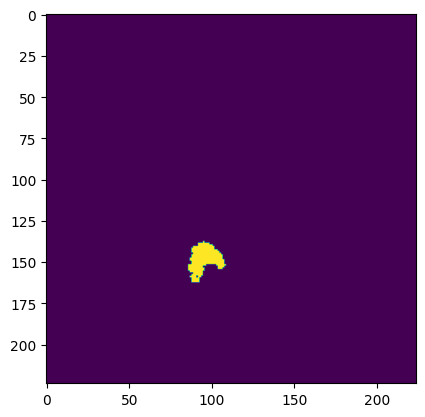

In [45]:
plt.imshow(a[5, 0].numpy())

In [28]:
a, b = dataset[0]
a.shape, b.shap

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

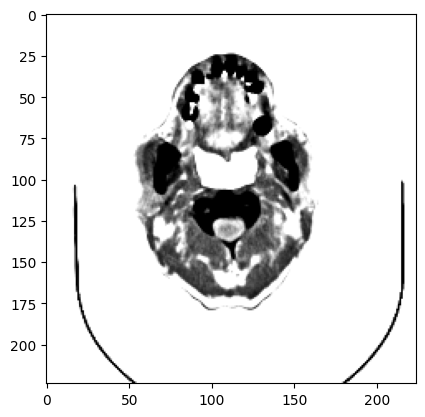

In [37]:
plt.imshow(1 - a[1], cmap="gray")

In [20]:
loader = DataLoader(
    dataset, batch_size=4, num_workers=5, drop_last=True, pin_memory=True, shuffle=True
)

In [21]:
args_yaml.model_params

Munch({'attention_type': 'scse', 'cls_activation': None, 'cls_dropout': '', 'cls_pooling': 'avg', 'decoder_channels': (256, 128, 64, 32, 16), 'depth': 5, 'encoder_name': 'efficientnet-b6', 'in_channels': 3, 'kernel_size': 3, 'n_maps': 1, 'num_classes': 2, 'output_stride': 32, 'seg_activation': None, 'task': ['segmentation'], 'use_batchnorm': True})

In [22]:
args_yaml.model_params

Munch({'attention_type': 'scse', 'cls_activation': None, 'cls_dropout': '', 'cls_pooling': 'avg', 'decoder_channels': (256, 128, 64, 32, 16), 'depth': 5, 'encoder_name': 'efficientnet-b6', 'in_channels': 3, 'kernel_size': 3, 'n_maps': 1, 'num_classes': 2, 'output_stride': 32, 'seg_activation': None, 'task': ['segmentation'], 'use_batchnorm': True})

In [23]:
device = torch.device("cuda:0")
net = args.model(args_yaml).double().to(device)

In [132]:
a, b = next(iter(loader))
a.shape, b.shape

ValueError: Cannot take a larger sample than population when 'replace=False'

In [25]:
b_ = net(a.double().to(device))
b_

{'bottleneck': tensor([[[[ 1.2986e+00,  4.2459e+00,  2.8707e-02,  ..., -2.1694e-02,
            -5.7371e-01,  3.2544e-01],
           [ 4.1972e+00,  1.2084e+00,  2.0003e+00,  ...,  6.2121e+00,
             3.6535e+00,  1.9038e+00],
           [ 6.2838e+00,  5.5532e+00,  5.2816e+00,  ...,  6.0779e+00,
             5.2231e+00,  1.1180e+00],
           ...,
           [ 2.2596e+00,  2.1190e+00,  1.0587e+00,  ..., -1.7133e+00,
            -2.7287e+00, -3.9565e+00],
           [ 1.1604e+00, -5.4772e-01, -1.7022e+00,  ..., -2.9679e+00,
            -3.4359e+00, -2.7978e+00],
           [-4.3790e+00,  1.4270e+00,  5.0571e-01,  ..., -2.7032e+00,
            -3.3087e+00, -5.0852e+00]],
 
          [[ 1.2102e+00,  1.0155e+00,  3.6901e-01,  ..., -1.2052e+00,
             5.3189e-01,  1.6197e+00],
           [ 1.0200e+00,  3.0188e-01,  8.6630e-01,  ..., -7.6782e-01,
             1.6227e+00,  6.0388e-01],
           [ 1.2882e+00, -9.6776e-01,  6.3823e-01,  ..., -1.5994e+00,
             1.0503e+00, 

In [26]:
args_yaml.metrics

Munch({'dice_metric': <monai.metrics.meandice.DiceMetric object at 0x7fb1234f99a0>, 'mse_metric': <monai.metrics.regression.MSEMetric object at 0x7fb1234f99d0>})

In [27]:
str(args_yaml.metrics[0]).split(" ")[0].split(".")[-1]

KeyError: 0

In [ ]:
args_yaml.losses[0](b.double(), b.double())
args_yaml.losses[1](b.double(), b.double())
args_yaml.losses[2](b.double(), b.double())

In [356]:
from qtrain.models.qer_multitask.multitask import MultiTaskNet
from qtrain.models.unet.multitasker import MultiTaskSeqAttn

In [362]:
model = MultiTaskSeqAttn(args.model_params)

In [358]:
model

MultiTaskSeqAttn(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReL

In [364]:
out = model(torch.randn(2,64,3,224,224), False)

In [365]:
out.keys()

dict_keys(['masks', 'slc_logits', 'acute_chronic_logits', 'features'])

In [345]:
out['slice_embeddings'].shape

torch.Size([2, 64, 1040])

In [346]:
out['dummy_layer_acute_chronic'].shape

torch.Size([2, 64, 4])

In [ ]:
[0.9,0.9]

In [361]:
for key in out.keys():
    print(key, out[key].shape)

masks torch.Size([2, 64, 2, 224, 224])
slc_logits torch.Size([2, 64, 2])
acute_chronic_logits torch.Size([2, 2])


AttributeError: 'list' object has no attribute 'shape'

In [337]:
F.sigmoid(out["acute_chronic_logits"])

tensor([[0.6511, 0.4798],
        [0.6207, 0.5057]], grad_fn=<SigmoidBackward0>)